In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotx
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import gc


matplotx.styles.duftify(matplotx.styles.dracula)

torch.manual_seed(42)
np.random.seed(42)

# 1. 数据导入和预处理
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()
        
    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据转换
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 加载数据集
train_dataset = EmotionDataset('./data/train', transform=transform)
test_dataset = EmotionDataset('./data/test', transform=transform)

# 数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:

# 2. 搭建第一个CNN模型
class FirstCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FirstCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_activations(self, x):
        activations = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                activations = x 
        return activations

# 3. 训练第一个模型或加载已训练模型
def train_model(model, train_loader, test_loader, num_epochs=20, model_path='first_model.pth'):
    if os.path.exists(model_path):
        print(f"加载已训练模型: {model_path}")
        model.load_state_dict(torch.load(model_path))
        return model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 测试集评估
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), model_path)
    

    with plt.style.context(matplotx.styles.duftify(matplotx.styles.nord)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Loss plot
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, label='Training Loss', linewidth=2.5)
        ax1.plot(epochs, test_losses, label='Validation Loss', linewidth=2.5)
        ax1.set_xlabel('Epoch')
        matplotx.ylabel_top('Loss', ax=ax1)
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(epochs, train_accs, label='Training Accuracy', linewidth=2.5)
        ax2.plot(epochs, test_accs, label='Validation Accuracy', linewidth=2.5)
        ax2.set_xlabel('Epoch')
        matplotx.ylabel_top('Accuracy', ax=ax2)
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    return model

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader), correct / total


In [5]:
# 训练第一个模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
first_model = FirstCNN()


if os.path.exists('first_model.pth'):
    print("加载已训练的第一个模型: first_model.pth")
    first_model.load_state_dict(torch.load('first_model.pth'))
    first_model = first_model.to(device)
else:
    print("开始训练第一个模型...")
    first_model = train_model(first_model, train_loader, test_loader, num_epochs=10, model_path='first_model.pth')


cuda
加载已训练的第一个模型: first_model.pth


C:\Users\33507\AppData\Local\Temp\ipykernel_28428\1270416820.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model.load_state_dict(torch.load('first_model.pth'))


d:\test\Anaconda\envs\emotion_recognition\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


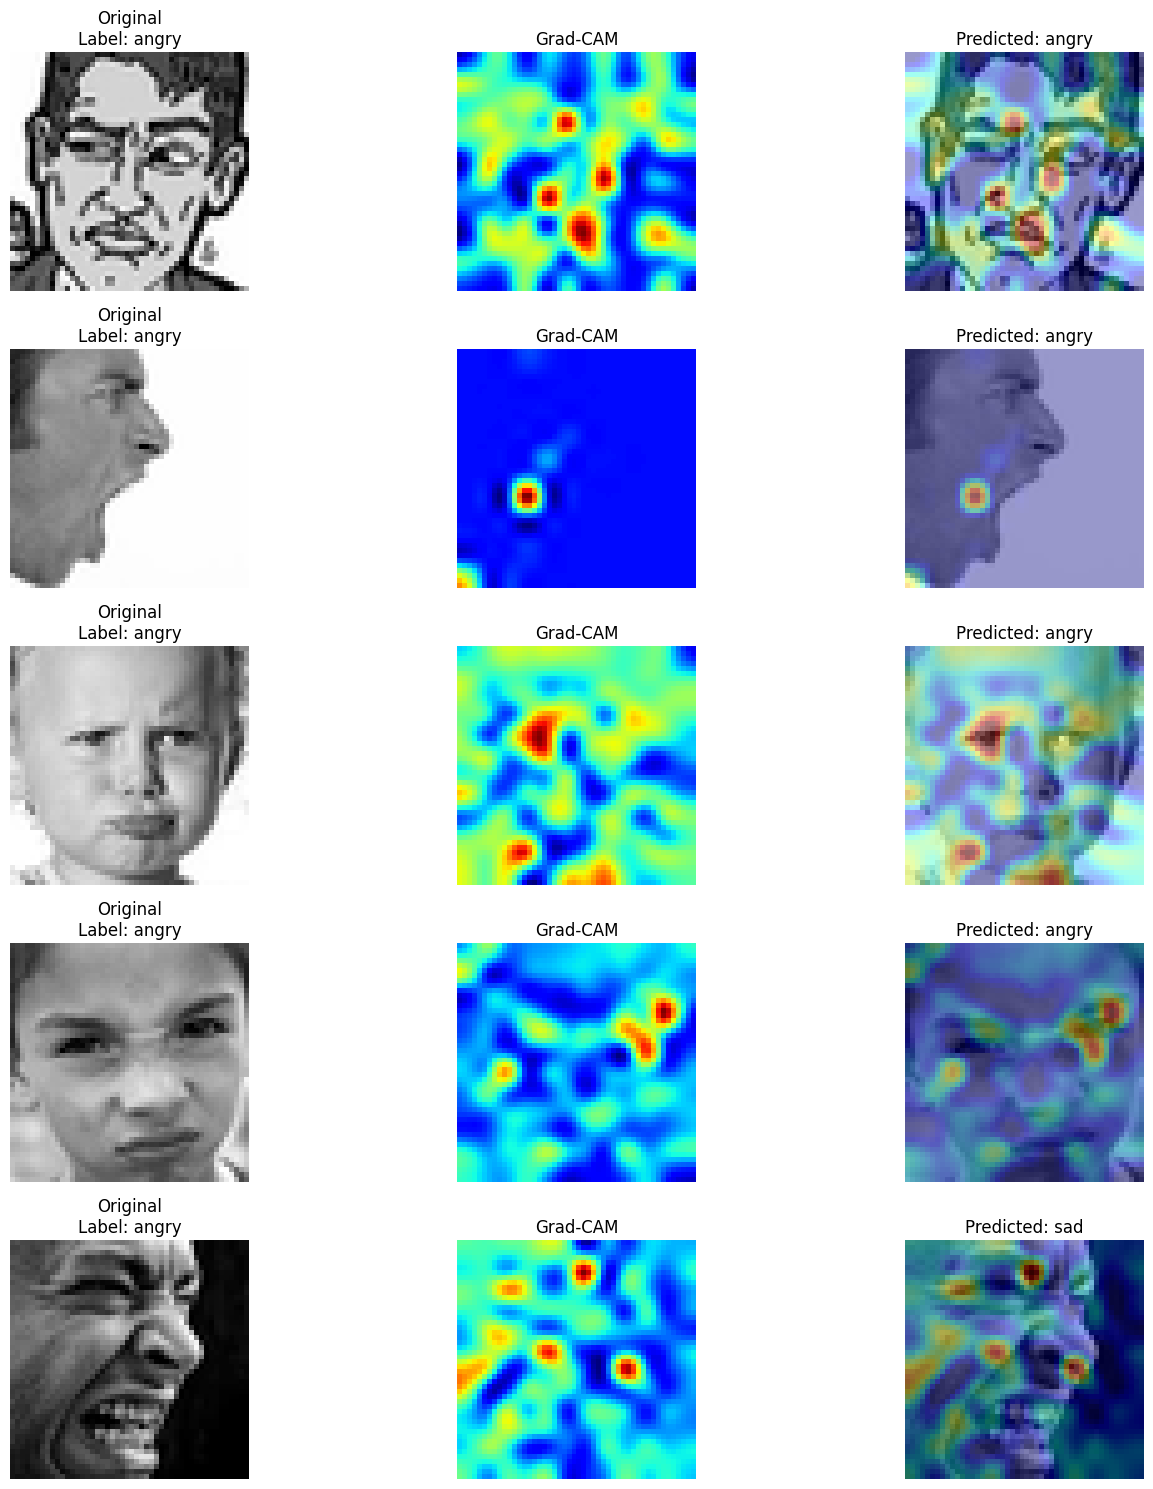

In [6]:


# 4. 可视化第一个模型预测的重要区域 (使用Grad-CAM)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        device = next(self.model.parameters()).device

        # 确保输入需要梯度
        x = x.clone().requires_grad_(True)

        # 前向传播
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        # 创建one-hot编码
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        # 反向传播
        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        # 计算权重
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # 计算CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        cam = cam.squeeze().cpu().numpy()

        return cam


# 获取目标层
target_layer = first_model.features[-2]  # 最后一个卷积层前的ReLU层

# 创建Grad-CAM实例
grad_cam = GradCAM(first_model, target_layer)


# 可视化一些样本的重要区域
def visualize_gradcam(loader, model, grad_cam, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    samples = []
    for inputs, labels in loader:
        samples.append((inputs[0], labels[0]))
        if len(samples) >= num_samples:
            break

    plt.figure(figsize=(15, 3 * num_samples))
    for i, (img, label) in enumerate(samples):
        # 临时启用梯度计算
        with torch.set_grad_enabled(True):
            img = img.unsqueeze(0).to(device).requires_grad_(True)
            output = model(img)
            pred_class = torch.argmax(output).item()
            cam = grad_cam(img, pred_class)
            cam = Image.fromarray(cam).resize((48, 48), Image.LANCZOS)
            cam = np.array(cam)

            # 原始图像 (灰度图处理)
            original_img = img.squeeze().detach().cpu().numpy()
            original_img = (original_img * 0.5 + 0.5) * 255  # 反归一化
            original_img = original_img.astype(np.uint8)

            # 叠加热力图 (灰度图特殊处理)
            heatmap = plt.cm.jet(cam)[..., :3] * 255  # 获取RGB热力图
            original_img_rgb = np.stack([original_img] * 3, axis=-1)  # 灰度转伪彩色
            superimposed_img = heatmap * 0.4 + original_img_rgb * 0.6
            superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

            # 显示
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(original_img, cmap="gray")
            plt.title(f"Original\nLabel: {test_dataset.classes[label]}")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(cam, cmap="jet")
            plt.title("Grad-CAM")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(superimposed_img)
            plt.title(f"Predicted: {test_dataset.classes[pred_class]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_gradcam(test_loader, first_model, grad_cam, num_samples=5)


# 5. 根据重要区域分片并训练第二个模型
def crop_important_region(img, cam, crop_size=24):
    """裁剪图像中的重要区域
    Args:
        img: 输入图像(PIL Image或张量)
        cam: 热力图(NumPy数组)
        crop_size: 裁剪区域大小
    Returns:
        裁剪后的图像(与输入同类型)
    """
    # 找到热力图中响应最大的区域
    h, w = cam.shape
    y, x = np.unravel_index(np.argmax(cam), cam.shape)

    # 计算裁剪区域边界
    x_min = max(0, x - crop_size // 2)
    x_max = min(w, x + crop_size // 2)
    y_min = max(0, y - crop_size // 2)
    y_max = min(h, y + crop_size // 2)

    # 确保区域大小一致(边界情况)
    if x_max - x_min < crop_size:
        if x_min == 0:
            x_max = min(w, x_min + crop_size)
        else:
            x_min = max(0, x_max - crop_size)

    if y_max - y_min < crop_size:
        if y_min == 0:
            y_max = min(h, y_min + crop_size)
        else:
            y_min = max(0, y_max - crop_size)

    # 根据输入类型进行裁剪
    if isinstance(img, Image.Image):  # PIL Image
        cropped_img = img.crop((x_min, y_min, x_max, y_max))
    elif isinstance(img, torch.Tensor):  # PyTorch张量
        cropped_img = img[:, y_min:y_max, x_min:x_max]
    elif isinstance(img, np.ndarray):  # NumPy数组
        cropped_img = img[y_min:y_max, x_min:x_max]
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")

    return cropped_img


class CroppedEmotionDataset(Dataset):
    def __init__(
        self,
        original_dataset,
        model,
        grad_cam,
        crop_size=24,
        device="cpu",
        transform=None,
    ):
        """
        Args:
            original_dataset: 原始数据集
            model: 用于生成CAM的模型
            grad_cam: GradCAM类实例
            crop_size: 裁剪区域大小(默认24)
            device: 计算设备(默认'cuda')
            transform: 应用于裁剪后图像的转换(可选)
        """
        self.original_dataset = original_dataset
        self.model = model
        self.grad_cam = grad_cam
        self.crop_size = crop_size
        self.device = device
        self.transform = transform  # 存储transform参数

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]

        # 转换为PIL Image用于裁剪(如果还不是)
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img.squeeze(0))
        elif isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img)
        else:
            img_pil = img  # 假设已经是PIL Image

        # 生成热力图
        img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(self.device)
        img_tensor = img_tensor.requires_grad_(True)

        with torch.set_grad_enabled(True):
            output = self.model(img_tensor)
            pred_class = torch.argmax(output).item()
            cam = self.grad_cam(img_tensor, pred_class)  # 假设返回的是张量
            if isinstance(cam, torch.Tensor):  # 确保是张量
                cam = cam.detach().cpu().numpy()

        # 裁剪重要区域
        cropped_img = crop_important_region(img_pil, cam, self.crop_size)

        # 应用转换(如果存在)
        if self.transform is not None:
            cropped_img = self.transform(cropped_img)

        return cropped_img, label


# 创建裁剪后的数据集
cropped_train_dataset = CroppedEmotionDataset(train_dataset, first_model, grad_cam)
cropped_test_dataset = CroppedEmotionDataset(test_dataset, first_model, grad_cam)

# 调整转换器以适应裁剪后的尺寸
cropped_transform = transforms.Compose([
    transforms.Resize((24, 24)),  # 调整到统一大小
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 应用转换
def apply_transform(dataset, transform):
    for i in range(len(dataset)):
        img, label = dataset[i]

        # 如果已经是张量，先转换为PIL图像
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = img

        dataset[i] = (transform(img_pil), label)
    return dataset


cropped_train_dataset = CroppedEmotionDataset(
    train_dataset,
    first_model,
    grad_cam,
    crop_size=24,
    device="cuda",
    transform=cropped_transform,  # transform在这里传入
)
cropped_test_dataset = CroppedEmotionDataset(
    test_dataset,
    first_model,
    grad_cam,
    crop_size=24,
    device="cuda",
    transform=cropped_transform,  # transform在这里传入
)

# 创建裁剪后的数据加载器
cropped_train_loader = DataLoader(cropped_train_dataset, batch_size=batch_size, shuffle=True)
cropped_test_loader = DataLoader(cropped_test_dataset, batch_size=batch_size, shuffle=False)

# 6. 搭建第二个CNN模型 (针对裁剪后的图像)
class SecondCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SecondCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [7]:
# 训练第二个模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
second_model = SecondCNN()

# 检查是否已有训练好的模型
if os.path.exists('second_model.pth'):
    print("加载已训练的第二个模型: second_model.pth")
    second_model.load_state_dict(torch.load('second_model.pth'))
    second_model = second_model.to(device)
else:
    print("开始训练第二个模型...")
    second_model = train_model(second_model, cropped_train_loader, cropped_test_loader, 
                              num_epochs=10, model_path='second_model.pth')



cuda
加载已训练的第二个模型: second_model.pth


C:\Users\33507\AppData\Local\Temp\ipykernel_28428\1184918954.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  second_model.load_state_dict(torch.load('second_model.pth'))


Evaluating First Model...


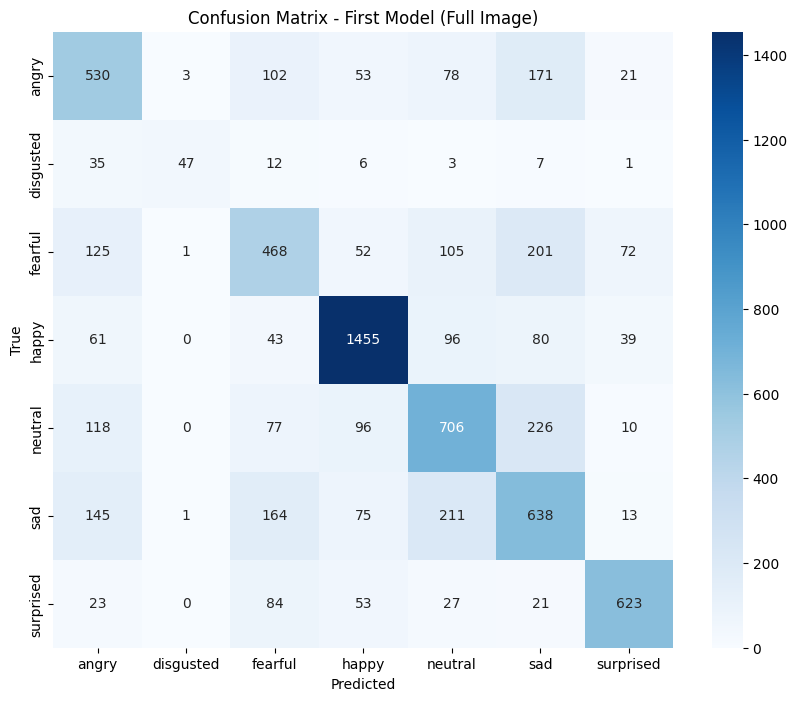

C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(test_dataset.classes, r

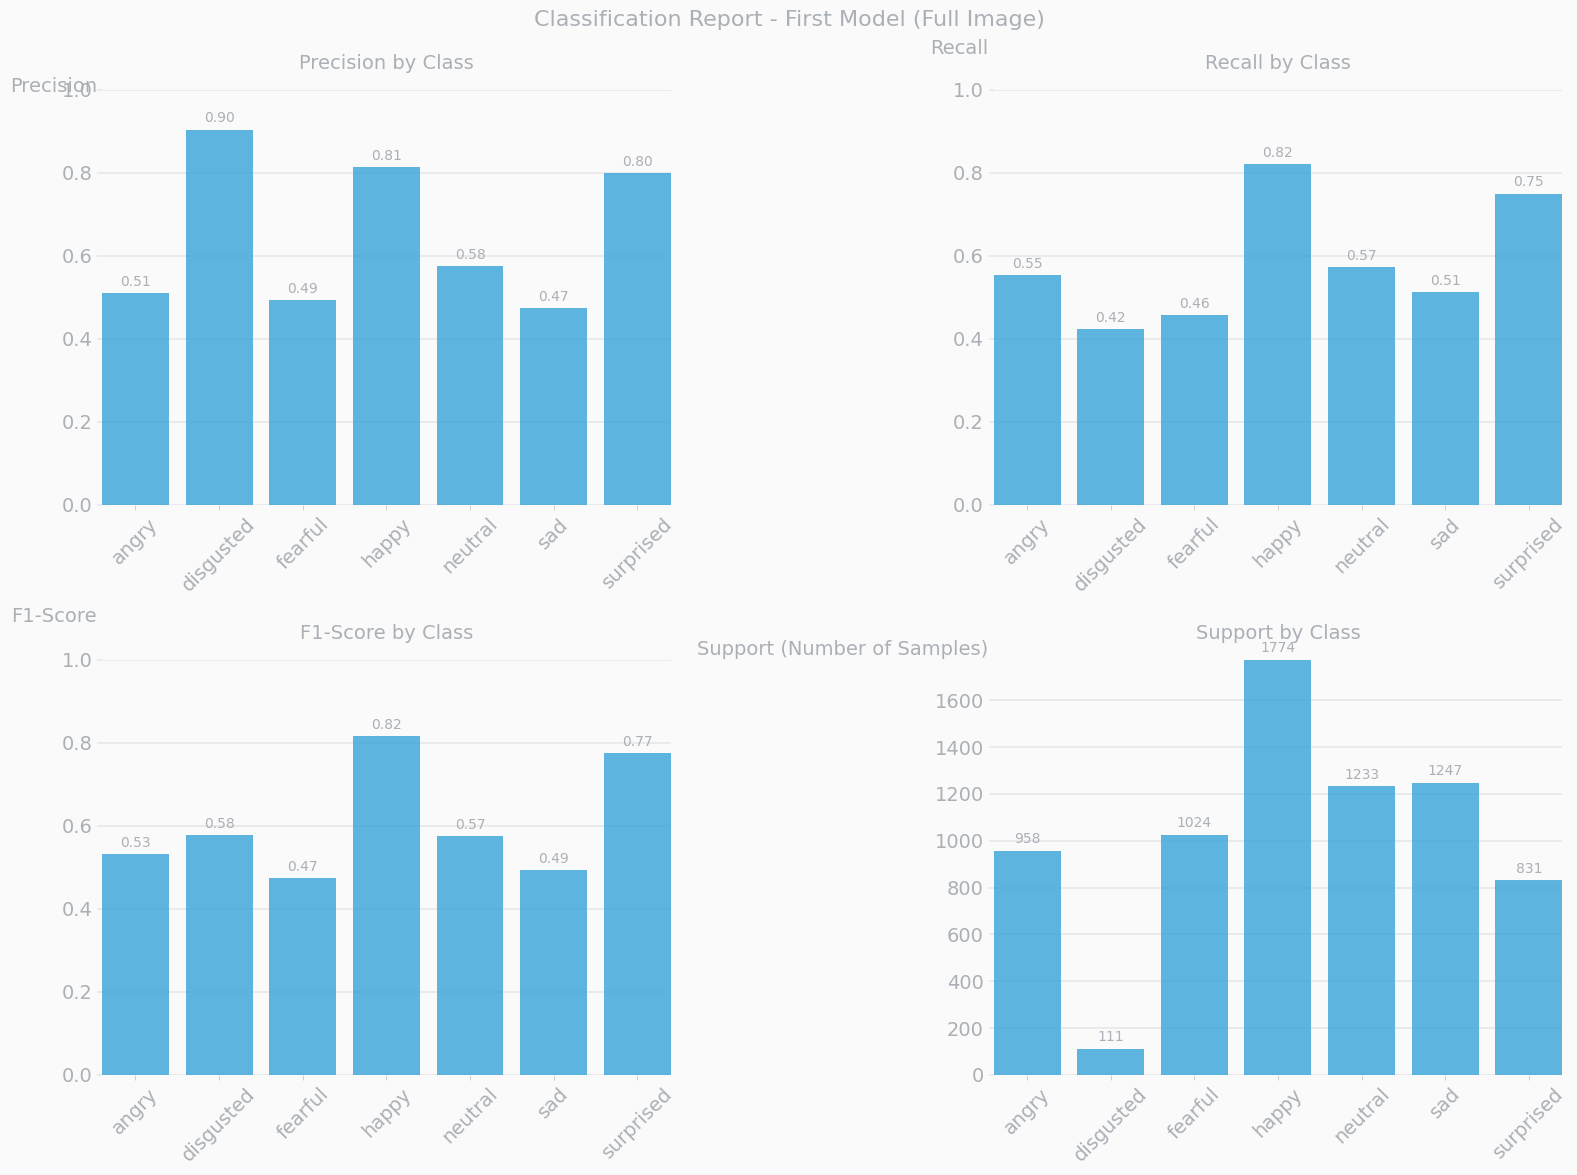


Classification Report - First Model (Full Image):

              precision    recall  f1-score   support

       angry       0.51      0.55      0.53       958
   disgusted       0.90      0.42      0.58       111
     fearful       0.49      0.46      0.47      1024
       happy       0.81      0.82      0.82      1774
     neutral       0.58      0.57      0.57      1233
         sad       0.47      0.51      0.49      1247
   surprised       0.80      0.75      0.77       831

    accuracy                           0.62      7178
   macro avg       0.65      0.58      0.61      7178
weighted avg       0.63      0.62      0.62      7178


Evaluating Second Model...


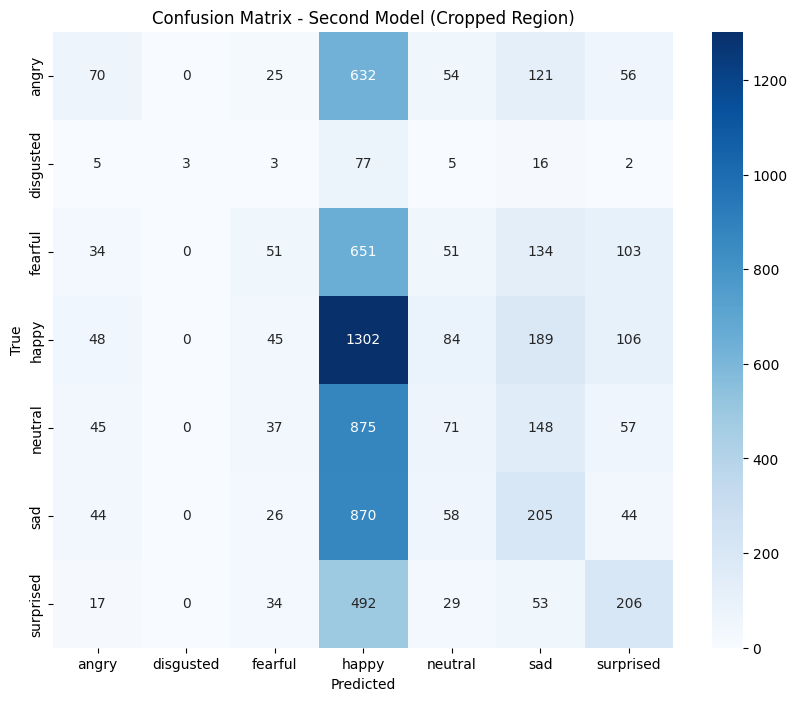

C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\2274824127.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(test_dataset.classes, r

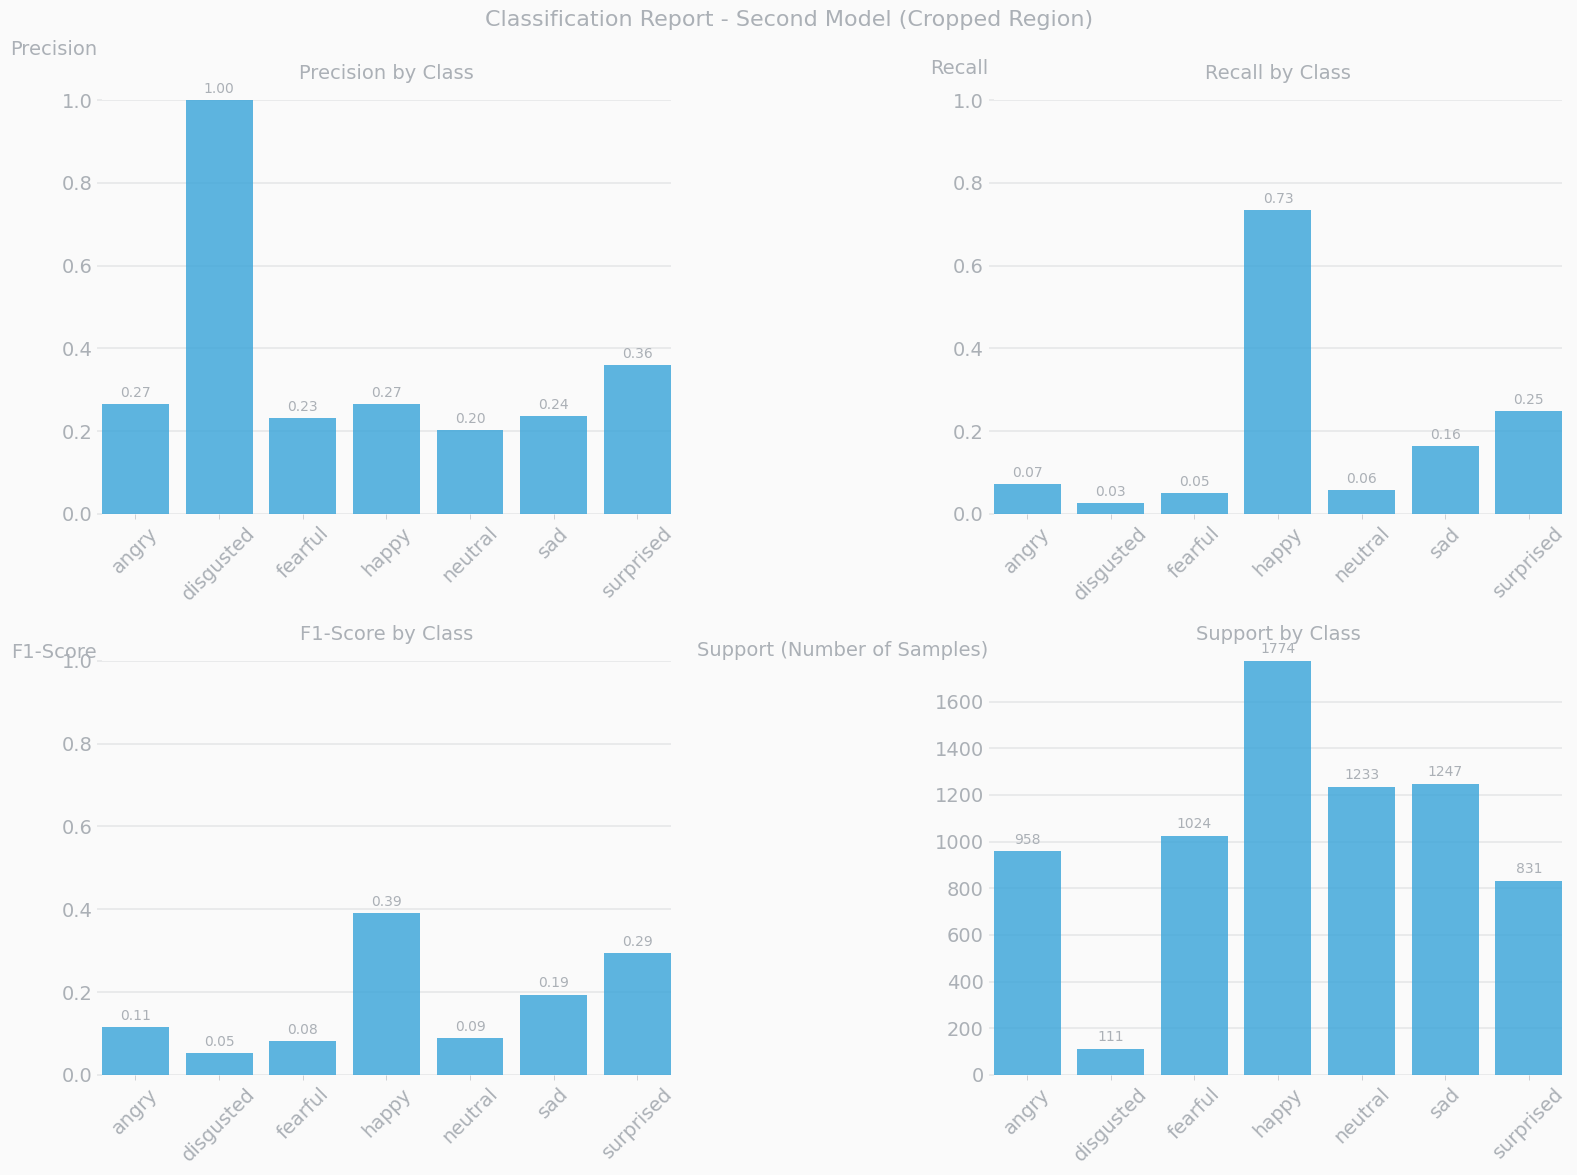


Classification Report - Second Model (Cropped Region):

              precision    recall  f1-score   support

       angry       0.27      0.07      0.11       958
   disgusted       1.00      0.03      0.05       111
     fearful       0.23      0.05      0.08      1024
       happy       0.27      0.73      0.39      1774
     neutral       0.20      0.06      0.09      1233
         sad       0.24      0.16      0.19      1247
   surprised       0.36      0.25      0.29       831

    accuracy                           0.27      7178
   macro avg       0.37      0.19      0.17      7178
weighted avg       0.27      0.27      0.21      7178



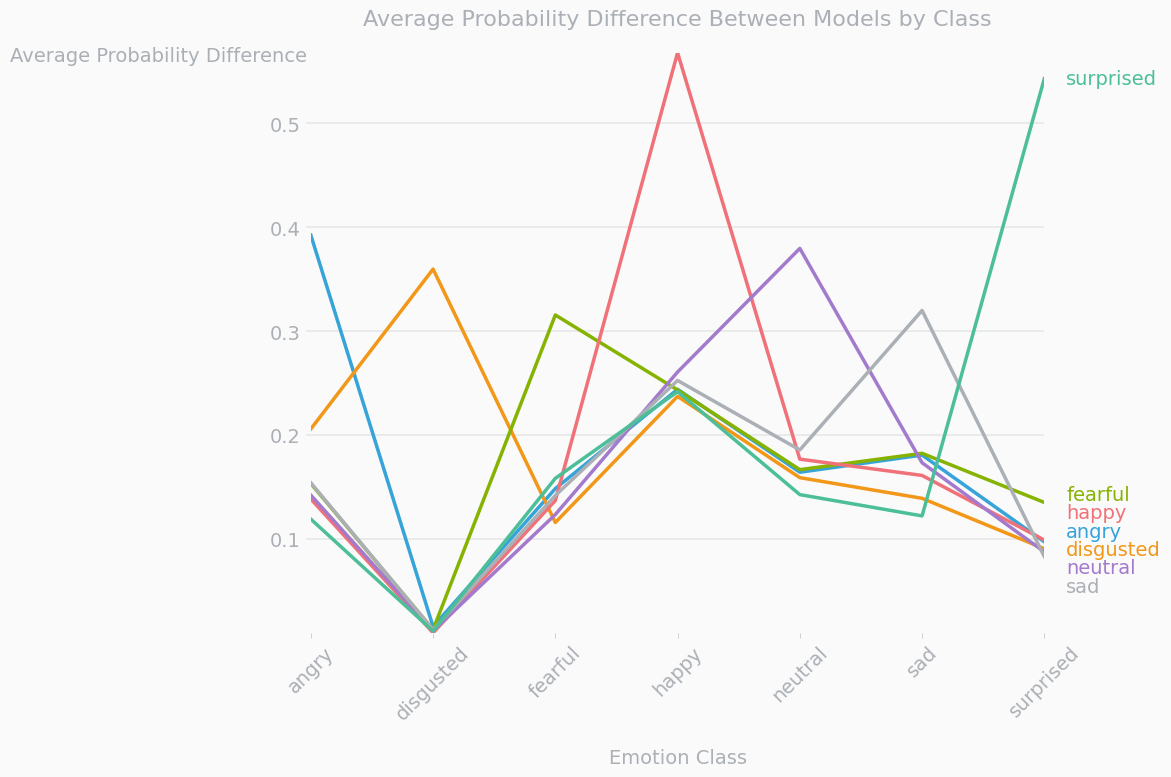

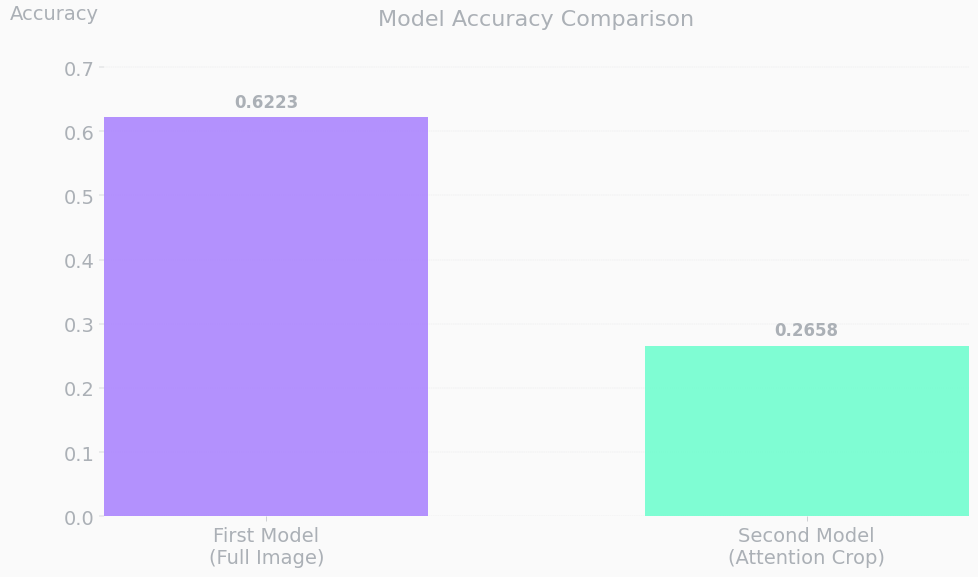

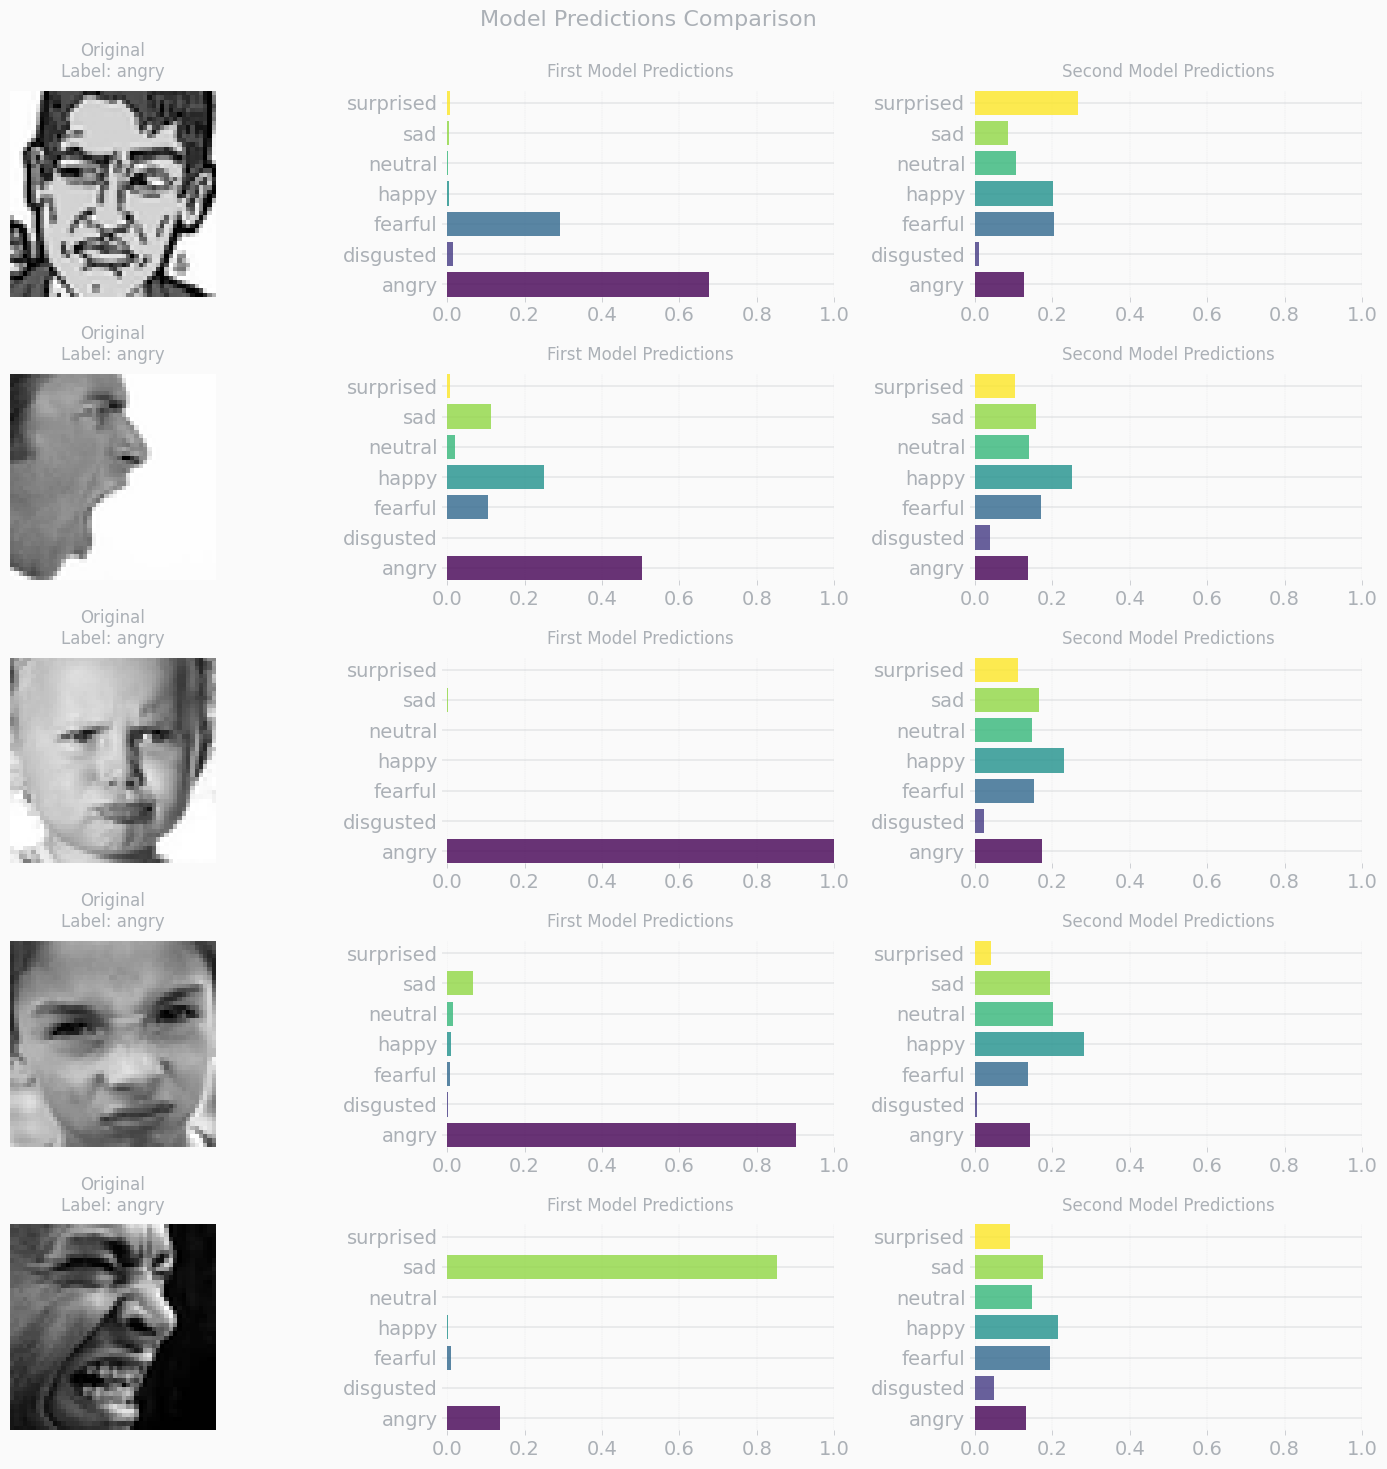

In [8]:
# 7. 分析两个模型的性能
def evaluate_and_plot(model, loader, title):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 绘制热力图 (保持原样式)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_dataset.classes,
        yticklabels=test_dataset.classes,
    )
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 获取分类报告数据
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)
    
    # 可视化分类报告 (使用matplotx ayu light样式)
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.ayu["light"])):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Precision条形图
        bars1 = ax1.bar(test_dataset.classes, precision, alpha=0.8)
        ax1.set_title('Precision by Class', fontsize=14, pad=15)
        matplotx.ylabel_top('Precision', ax=ax1)
        ax1.set_xticklabels(test_dataset.classes, rotation=45)
        ax1.set_ylim(0, 1)
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)
        
        # Recall条形图
        bars2 = ax2.bar(test_dataset.classes, recall, alpha=0.8)
        ax2.set_title('Recall by Class', fontsize=14, pad=15)
        matplotx.ylabel_top('Recall', ax=ax2)
        ax2.set_xticklabels(test_dataset.classes, rotation=45)
        ax2.set_ylim(0, 1)
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)
        
        # F1-Score条形图
        bars3 = ax3.bar(test_dataset.classes, f1, alpha=0.8)
        ax3.set_title('F1-Score by Class', fontsize=14, pad=15)
        matplotx.ylabel_top('F1-Score', ax=ax3)
        ax3.set_xticklabels(test_dataset.classes, rotation=45)
        ax3.set_ylim(0, 1)
        for i, bar in enumerate(bars3):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)
        
        # Support条形图
        bars4 = ax4.bar(test_dataset.classes, support, alpha=0.8)
        ax4.set_title('Support by Class', fontsize=14, pad=15)
        matplotx.ylabel_top('Support (Number of Samples)', ax=ax4)
        ax4.set_xticklabels(test_dataset.classes, rotation=45)
        for i, bar in enumerate(bars4):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        plt.suptitle(f'Classification Report - {title}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()

    # 打印分类报告
    print(f"\nClassification Report - {title}:\n")
    print(
        classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    )

    # 返回准确率
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    return accuracy

# 评估第一个模型
print("\nEvaluating First Model...")
first_model_accuracy = evaluate_and_plot(
    first_model, test_loader, "First Model (Full Image)"
)

# 评估第二个模型
print("\nEvaluating Second Model...")
second_model_accuracy = evaluate_and_plot(
    second_model, cropped_test_loader, "Second Model (Cropped Region)"
)


# 8. 对比两个模型的性能
def compare_models(first_model, second_model, test_loader, cropped_test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 获取两个模型在所有测试样本上的预测概率
    first_model_probs = []
    second_model_probs = []
    true_labels = []

    first_model.eval()
    second_model.eval()

    with torch.no_grad():
        # 第一个模型的预测
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = first_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            first_model_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.numpy())

        # 第二个模型的预测
        for inputs, labels in cropped_test_loader:
            inputs = inputs.to(device)
            outputs = second_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            second_model_probs.extend(probs.cpu().numpy())

    # 转换为numpy数组
    first_model_probs = np.array(first_model_probs)
    second_model_probs = np.array(second_model_probs)
    true_labels = np.array(true_labels)

    # 计算每个样本两个模型的预测差异
    prob_diffs = np.abs(first_model_probs - second_model_probs)
    avg_diff_per_class = [
        np.mean(prob_diffs[true_labels == i], axis=0)
        for i in range(len(test_dataset.classes))
    ]

    # 使用matplotx ayu light样式绘制图表
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.ayu["light"])):
        # 绘制每个类别的概率差异
        plt.figure(figsize=(12, 8))
        for i, class_name in enumerate(test_dataset.classes):
            plt.plot(avg_diff_per_class[i], label=class_name, linewidth=2.5)

        plt.title("Average Probability Difference Between Models by Class", fontsize=16, pad=20)
        plt.xlabel("Emotion Class")
        matplotx.ylabel_top("Average Probability Difference")
        plt.xticks(range(len(test_dataset.classes)), test_dataset.classes, rotation=45)
        matplotx.line_labels()
        plt.tight_layout()
        plt.show()

        # 绘制两个模型的准确率对比
        plt.figure(figsize=(10, 6))
        models = ["First Model\n(Full Image)", "Second Model\n(Attention Crop)"]
        accuracies = [first_model_accuracy, second_model_accuracy]
        colors = ['#A277FF', '#61FFCA']
        
        bars = plt.bar(models, accuracies, color=colors, alpha=0.8, width=0.6)

        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.4f}",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight='bold'
            )

        plt.title("Model Accuracy Comparison", fontsize=16, pad=20)
        matplotx.ylabel_top("Accuracy")
        plt.ylim(0, max(accuracies) + 0.1)
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()


# 对比两个模型
compare_models(first_model, second_model, test_loader, cropped_test_loader)


# 9. 可视化两个模型对同一批样本的预测
def visualize_predictions(
    first_model, second_model, loader, cropped_loader, num_samples=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 获取样本
    first_samples = []
    second_samples = []
    for (full_img, full_label), (cropped_img, _) in zip(loader, cropped_loader):
        first_samples.append((full_img[0], full_label[0]))
        second_samples.append(cropped_img[0])
        if len(first_samples) >= num_samples:
            break

    # 使用matplotx ayu light样式
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.ayu["light"])):
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
            
        for i in range(num_samples):
            full_img, full_label = first_samples[i]
            cropped_img = second_samples[i]

            # 第一个模型的预测
            full_input = full_img.unsqueeze(0).to(device)
            with torch.no_grad():
                full_output = first_model(full_input)
                full_probs = (
                    torch.nn.functional.softmax(full_output, dim=1).cpu().numpy()[0]
                )

            # 第二个模型的预测
            cropped_input = cropped_img.unsqueeze(0).to(device)
            with torch.no_grad():
                cropped_output = second_model(cropped_input)
                cropped_probs = (
                    torch.nn.functional.softmax(cropped_output, dim=1).cpu().numpy()[0]
                )

            # 显示原始图像
            original_img = full_img.squeeze().numpy()
            original_img = (original_img * 0.5 + 0.5) * 255  # 反归一化
            axes[i, 0].imshow(original_img, cmap="gray")
            axes[i, 0].set_title(f"Original\nLabel: {test_dataset.classes[full_label]}", fontsize=12, pad=10)
            axes[i, 0].axis("off")

            # 显示第一个模型的预测概率
            colors = plt.cm.viridis(np.linspace(0, 1, len(test_dataset.classes)))
            bars1 = axes[i, 1].barh(test_dataset.classes, full_probs, color=colors, alpha=0.8)
            axes[i, 1].set_title("First Model Predictions", fontsize=12, pad=10)
            axes[i, 1].set_xlim(0, 1)
            axes[i, 1].grid(axis='x', alpha=0.3, linestyle='--')

            # 显示第二个模型的预测概率
            bars2 = axes[i, 2].barh(test_dataset.classes, cropped_probs, color=colors, alpha=0.8)
            axes[i, 2].set_title("Second Model Predictions", fontsize=12, pad=10)
            axes[i, 2].set_xlim(0, 1)
            axes[i, 2].grid(axis='x', alpha=0.3, linestyle='--')

        plt.suptitle("Model Predictions Comparison", fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()


# 可视化预测对比
visualize_predictions(
    first_model, second_model, test_loader, cropped_test_loader, num_samples=5
)

准备训练数据...
正在处理数据集（全部 28709 个样本）...


100%|██████████| 28709/28709 [00:09<00:00, 3008.84it/s]


准备测试数据...
正在处理数据集（全部 7178 个样本）...


100%|██████████| 7178/7178 [00:02<00:00, 2932.02it/s]
d:\test\Anaconda\envs\emotion_recognition\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\test\Anaconda\envs\emotion_recognition\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\test\Anaconda\envs\emotion_recognition\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle est

训练集形状: (28709, 2304)
测试集形状: (7178, 2304)
特征维度: 2304

训练集每个类别的样本数量:
  angry: 3995
  disgusted: 436
  fearful: 4097
  happy: 7215
  neutral: 4965
  sad: 4830
  surprised: 3171

测试集每个类别的样本数量:
  angry: 958
  disgusted: 111
  fearful: 1024
  happy: 1774
  neutral: 1233
  sad: 1247
  surprised: 831
加载已训练的完整PCA+SVM模型: pca_svm_model_full.joblib

=== 完整PCA+SVM 模型评估 ===
正在进行预测...
测试集准确率: 0.4504


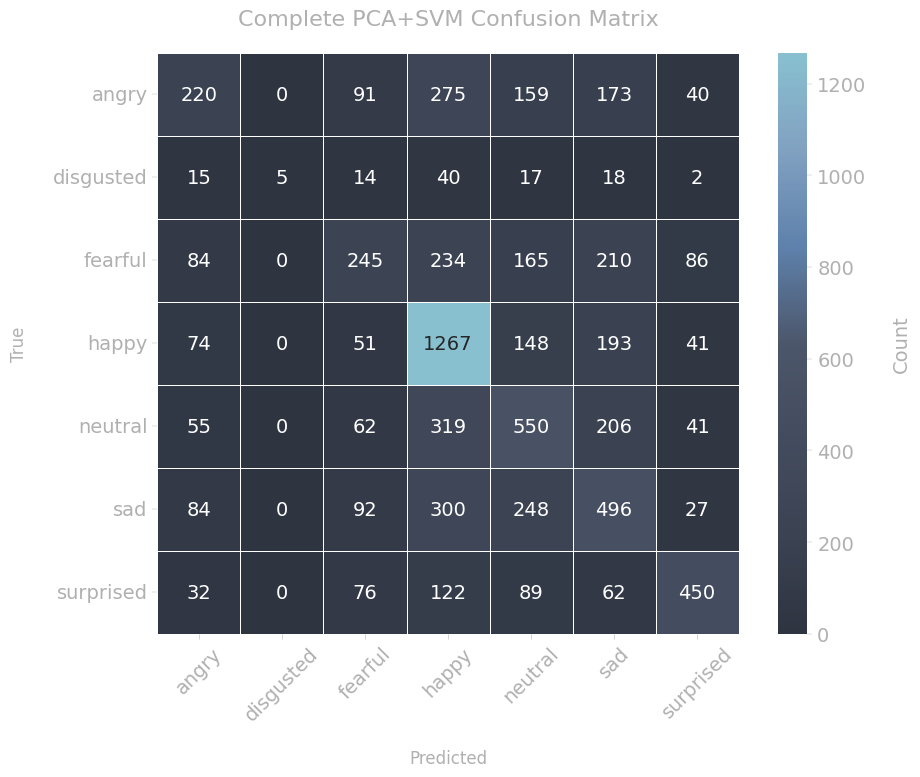


Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.23      0.29       958
   disgusted       1.00      0.05      0.09       111
     fearful       0.39      0.24      0.30      1024
       happy       0.50      0.71      0.59      1774
     neutral       0.40      0.45      0.42      1233
         sad       0.37      0.40      0.38      1247
   surprised       0.66      0.54      0.59       831

    accuracy                           0.45      7178
   macro avg       0.53      0.37      0.38      7178
weighted avg       0.45      0.45      0.43      7178


PCA信息:
保留的主成分数量: 269
解释的方差比例: 0.9501

每个类别的详细性能:
  angry: Precision=0.390, Recall=0.230, F1=0.289, Support=958
  disgusted: Precision=1.000, Recall=0.045, F1=0.086, Support=111
  fearful: Precision=0.388, Recall=0.239, F1=0.296, Support=1024
  happy: Precision=0.496, Recall=0.714, F1=0.585, Support=1774
  neutral: Precision=0.400, Recall=0.446, F1=0.422, Support=1233
  sad: P

C:\Users\33507\AppData\Local\Temp\ipykernel_28428\142096746.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(test_dataset.classes, rotation=45)
C:\Users\33507\AppData\Local\Temp\ipykernel_28428\142096746.py:243: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(test_dataset.classes, rotation=45)


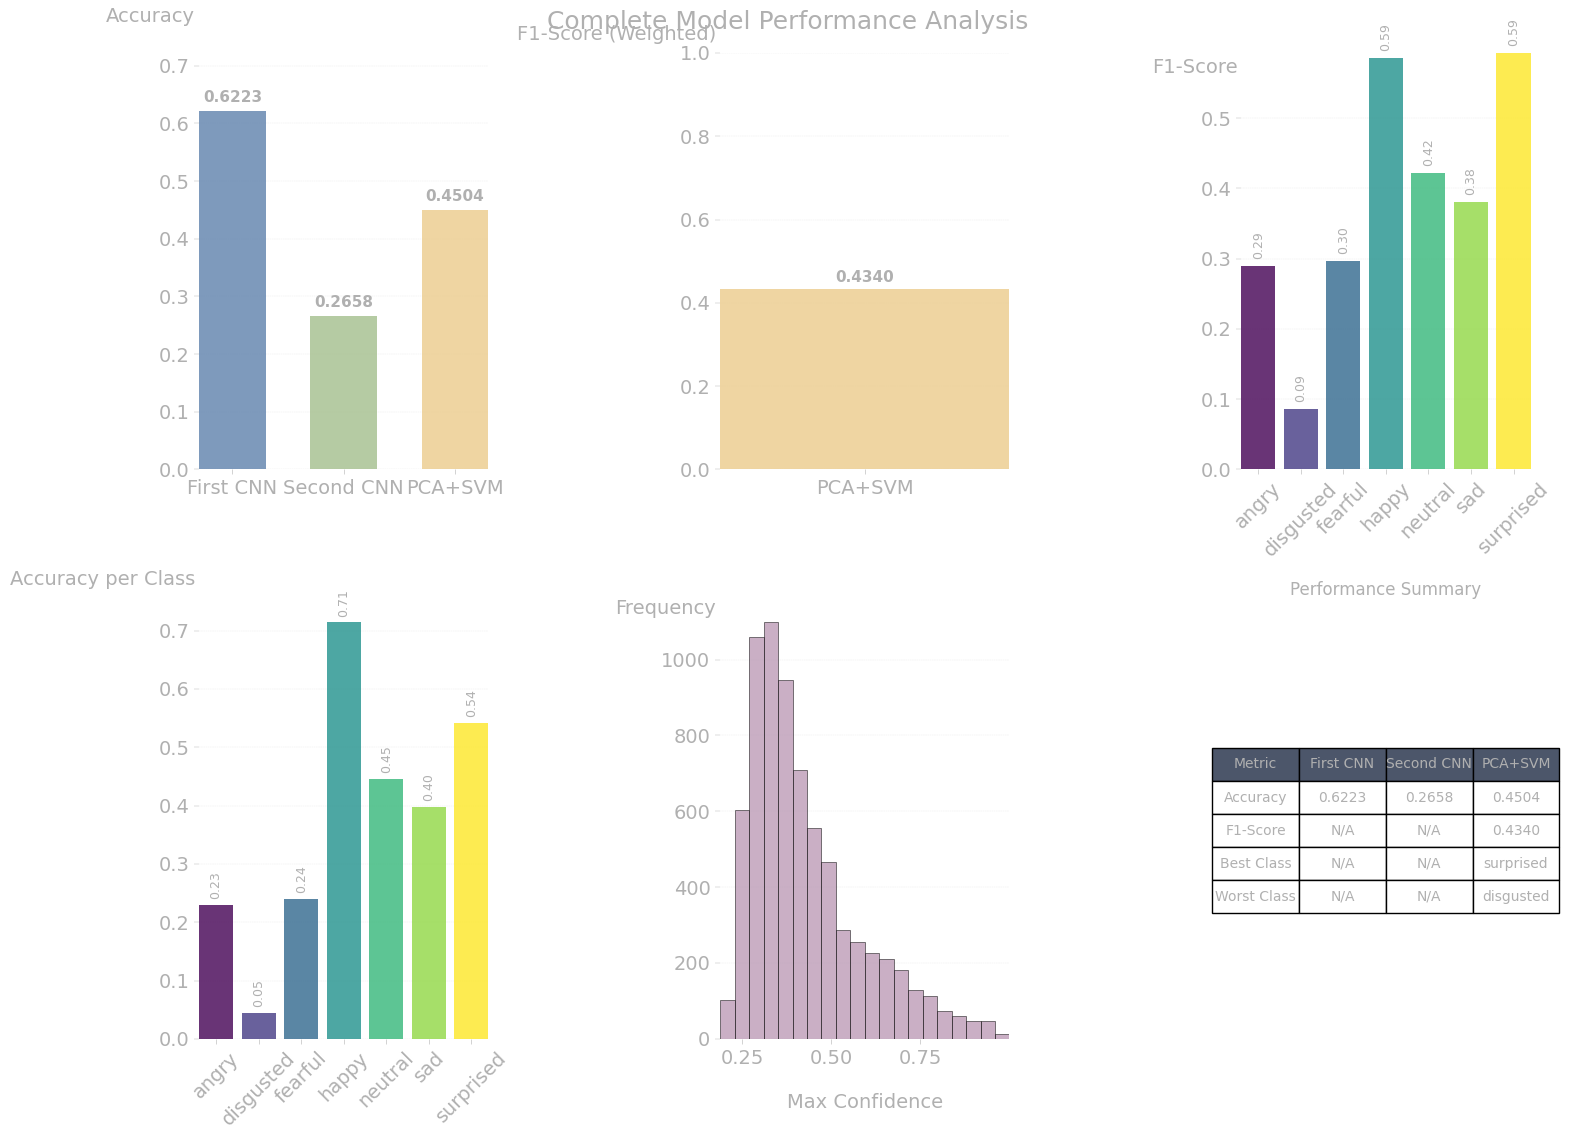


=== 完整模型性能总结 ===
First CNN 准确率: 0.6223
Second CNN 准确率: 0.2658
PCA+SVM (Full) 准确率: 0.4504
PCA+SVM (Full) F1-Score: 0.4340

最佳表现类别: surprised (F1: 0.593)
最差表现类别: disgusted (F1: 0.086)

=== 预测结果示例 ===
样本 1 ✓: 真实=neutral, 预测=neutral, 置信度=0.382
样本 2 ✓: 真实=sad, 预测=sad, 置信度=0.309
样本 3 ✗: 真实=surprised, 预测=happy, 置信度=0.644
样本 4 ✓: 真实=happy, 预测=happy, 置信度=0.574
样本 5 ✗: 真实=disgusted, 预测=angry, 置信度=0.072
样本 6 ✗: 真实=fearful, 预测=happy, 置信度=0.443
样本 7 ✗: 真实=angry, 预测=happy, 置信度=0.251
样本 8 ✗: 真实=surprised, 预测=fearful, 置信度=0.281
样本 9 ✓: 真实=happy, 预测=happy, 置信度=0.558
样本 10 ✗: 真实=fearful, 预测=sad, 置信度=0.357


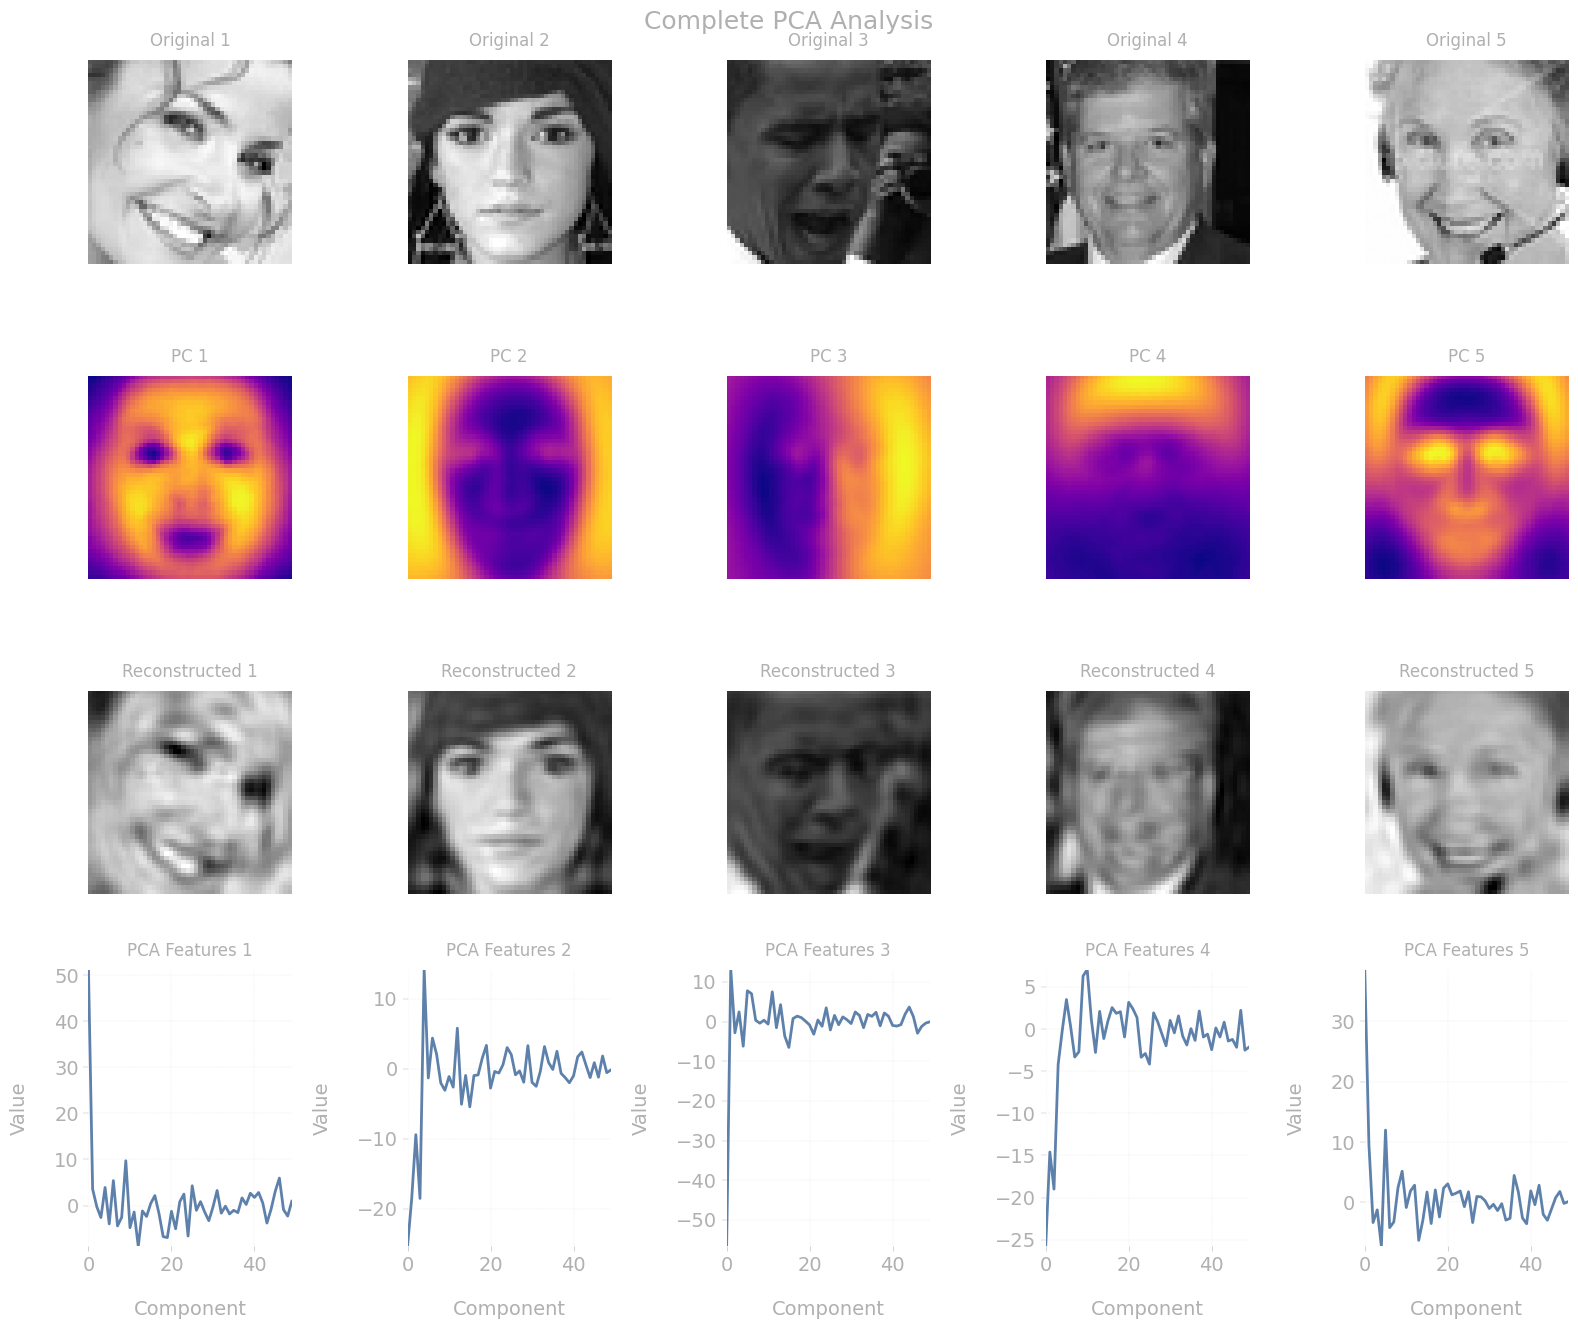

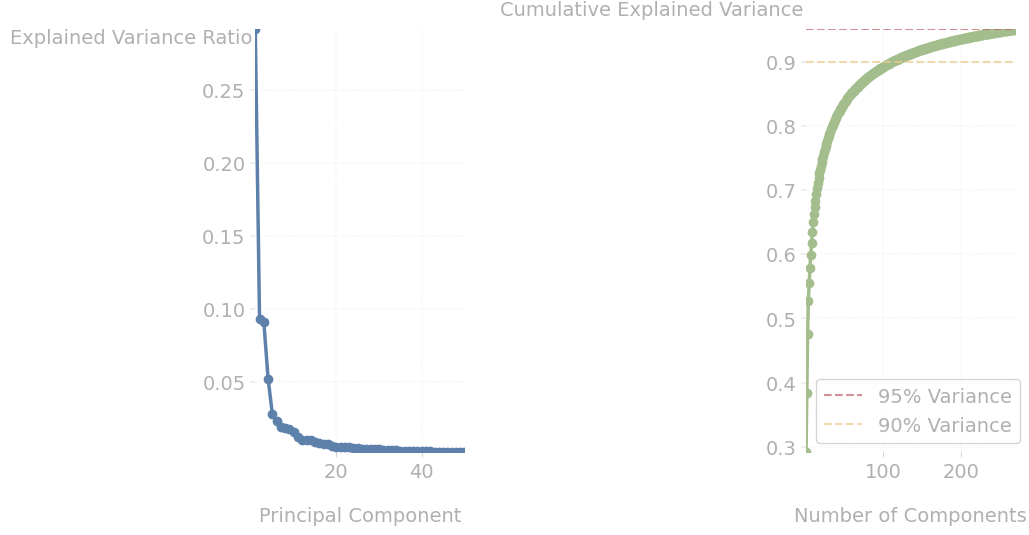


完整PCA+SVM 分析完成！


In [ ]:
# 10. PCA + SVM 方法（使用全部数据）

def prepare_data_for_sklearn_full(dataset):
    images = []
    labels = []
    
    print(f"正在处理数据集（全部 {len(dataset)} 个样本）...")
    
    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        
        if isinstance(img, torch.Tensor):
            img_np = img.numpy()
        else:
            img_np = np.array(img)
        img_flat = img_np.flatten()
        images.append(img_flat)
        labels.append(label)
    
    return np.array(images, dtype=np.float32), np.array(labels)


print("准备训练数据...")
X_train_full, y_train_full = prepare_data_for_sklearn_full(train_dataset)
print("准备测试数据...")
X_test_full, y_test_full = prepare_data_for_sklearn_full(test_dataset)

print(f"训练集形状: {X_train_full.shape}")
print(f"测试集形状: {X_test_full.shape}")
print(f"特征维度: {X_train_full.shape[1]}")


unique_train, counts_train = np.unique(y_train_full, return_counts=True)
unique_test, counts_test = np.unique(y_test_full, return_counts=True)

print("\n训练集每个类别的样本数量:")
for i, count in enumerate(counts_train):
    print(f"  {train_dataset.classes[i]}: {count}")

print("\n测试集每个类别的样本数量:")
for i, count in enumerate(counts_test):
    print(f"  {test_dataset.classes[i]}: {count}")

# 创建PCA+SVM管道
def create_full_pca_svm_pipeline():
    """创建完整的PCA+SVM处理管道"""
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('pca', PCA(n_components=0.95, random_state=42)),  # PCA降维，保留95%方差
        ('svm', SVC(C=1.0, kernel='rbf', random_state=42, probability=True))  # SVM分类器
    ])
    return pipeline

# 检查是否已有训练好的模型
pca_svm_model_path_full = 'pca_svm_model_full.joblib'

if os.path.exists(pca_svm_model_path_full):
    print(f"加载已训练的完整PCA+SVM模型: {pca_svm_model_path_full}")
    pca_svm_model_full = joblib.load(pca_svm_model_path_full)
else:
    print("开始训练完整的PCA+SVM模型...")
    
    pca_svm_model_full = create_full_pca_svm_pipeline()
    

    print("正在训练模型...")
    pca_svm_model_full.fit(X_train_full, y_train_full)
    
    joblib.dump(pca_svm_model_full, pca_svm_model_path_full)
    print(f"模型已保存到: {pca_svm_model_path_full}")

# 评估完整模型性能
def evaluate_full_pca_svm_model(model, X_test, y_test, class_names):
    """评估完整PCA+SVM模型性能"""
    print("\n=== 完整PCA+SVM 模型评估 ===")
    
    print("正在进行预测...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = np.mean(y_pred == y_test)
    print(f"测试集准确率: {accuracy:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    
    # Enhanced confusion matrix
    with plt.style.context(matplotx.styles.dufte):
        plt.figure(figsize=(10, 8))
        
        # Create custom colormap
        colors = ['#2E3440', '#3B4252', '#434C5E', '#4C566A', '#5E81AC', '#81A1C1', '#88C0D0']
        custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', colors, N=256)
        
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=custom_cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            square=True,
            linewidths=0.5
        )
        plt.title("Complete PCA+SVM Confusion Matrix", fontsize=16, pad=20)
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("True", fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    

    pca_component = model.named_steps['pca']
    print(f"\nPCA信息:")
    print(f"保留的主成分数量: {pca_component.n_components_}")
    print(f"解释的方差比例: {pca_component.explained_variance_ratio_.sum():.4f}")
    

    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    
    print(f"\n每个类别的详细性能:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")
    
    return accuracy, y_pred, y_pred_proba

# 评估完整PCA+SVM模型
pca_svm_accuracy_full, pca_svm_pred_full, pca_svm_proba_full = evaluate_full_pca_svm_model(
    pca_svm_model_full, X_test_full, y_test_full, test_dataset.classes
)

# 与CNN模型进行完整性能对比
def compare_all_models_complete():
    """对比所有模型的完整性能"""
    print("\n=== 完整模型性能对比 ===")
    
    with plt.style.context(matplotx.styles.dufte):
        fig = plt.figure(figsize=(16, 12))
        
        # 子图1: 准确率对比
        ax1 = plt.subplot(2, 3, 1)
        models = ["First CNN", "Second CNN", "PCA+SVM"]
        accuracies = [first_model_accuracy, second_model_accuracy, pca_svm_accuracy_full]
        colors = ['#5E81AC', '#A3BE8C', '#EBCB8B']
        
        bars = ax1.bar(models, accuracies, color=colors, alpha=0.8, width=0.6)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.4f}",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight='bold'
            )
        
        matplotx.ylabel_top("Accuracy", ax=ax1)
        ax1.set_ylim(0, max(accuracies) + 0.1)
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 子图2: F1分数对比
        ax2 = plt.subplot(2, 3, 2)
        from sklearn.metrics import f1_score
        
        f1_pca_svm_full = f1_score(y_test_full, pca_svm_pred_full, average='weighted')
        
        f1_scores = [f1_pca_svm_full]
        f1_models = ["PCA+SVM"]
        
        bars = ax2.bar(f1_models, f1_scores, color=['#EBCB8B'], alpha=0.8, width=0.4)
        for bar in bars:
            height = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.4f}",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight='bold'
            )
        
        matplotx.ylabel_top("F1-Score (Weighted)", ax=ax2)
        ax2.set_ylim(0, 1)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 子图3: 每个类别的F1分数
        ax3 = plt.subplot(2, 3, 3)
        f1_per_class = f1_score(y_test_full, pca_svm_pred_full, average=None)
        
        colors_class = plt.cm.viridis(np.linspace(0, 1, len(test_dataset.classes)))
        bars = ax3.bar(test_dataset.classes, f1_per_class, color=colors_class, alpha=0.8)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )
        
        matplotx.ylabel_top("F1-Score", ax=ax3)
        ax3.set_xticklabels(test_dataset.classes, rotation=45)
        ax3.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 子图4: 预测准确性分布
        ax4 = plt.subplot(2, 3, 4)
        correct_predictions = (pca_svm_pred_full == y_test_full)
        accuracy_per_class = []
        
        for i in range(len(test_dataset.classes)):
            class_mask = (y_test_full == i)
            if np.sum(class_mask) > 0:
                class_accuracy = np.mean(correct_predictions[class_mask])
                accuracy_per_class.append(class_accuracy)
            else:
                accuracy_per_class.append(0)
        
        bars = ax4.bar(test_dataset.classes, accuracy_per_class, color=colors_class, alpha=0.8)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax4.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )
        
        matplotx.ylabel_top("Accuracy per Class", ax=ax4)
        ax4.set_xticklabels(test_dataset.classes, rotation=45)
        ax4.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 子图5: 置信度分布
        ax5 = plt.subplot(2, 3, 5)
        max_confidences = np.max(pca_svm_proba_full, axis=1)
        
        ax5.hist(max_confidences, bins=20, alpha=0.7, color='#B48EAD', edgecolor='black', linewidth=0.5)
        ax5.set_xlabel("Max Confidence")
        matplotx.ylabel_top("Frequency", ax=ax5)
        ax5.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 子图6: 模型性能总结表
        ax6 = plt.subplot(2, 3, 6)
        
        performance_data = [
            ["Metric", "First CNN", "Second CNN", "PCA+SVM"],
            ["Accuracy", f"{first_model_accuracy:.4f}", f"{second_model_accuracy:.4f}", f"{pca_svm_accuracy_full:.4f}"],
            ["F1-Score", "N/A", "N/A", f"{f1_pca_svm_full:.4f}"],
            ["Best Class", "N/A", "N/A", test_dataset.classes[np.argmax(f1_per_class)]],
            ["Worst Class", "N/A", "N/A", test_dataset.classes[np.argmin(f1_per_class)]]
        ]
        
        table = ax6.table(
            cellText=performance_data[1:],
            colLabels=performance_data[0],
            cellLoc="center",
            loc="center",
            colColours=['#4C566A'] * 4
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2)
        ax6.axis("off")
        ax6.set_title("Performance Summary", fontsize=12, pad=20)
        
        plt.suptitle("Complete Model Performance Analysis", fontsize=18, y=0.95)
        plt.tight_layout()
        plt.show()
    
    # 打印详细总结
    print("\n=== 完整模型性能总结 ===")
    print(f"First CNN 准确率: {first_model_accuracy:.4f}")
    print(f"Second CNN 准确率: {second_model_accuracy:.4f}")
    print(f"PCA+SVM (Full) 准确率: {pca_svm_accuracy_full:.4f}")
    print(f"PCA+SVM (Full) F1-Score: {f1_pca_svm_full:.4f}")
    
    print(f"\n最佳表现类别: {test_dataset.classes[np.argmax(f1_per_class)]} (F1: {np.max(f1_per_class):.3f})")
    print(f"最差表现类别: {test_dataset.classes[np.argmin(f1_per_class)]} (F1: {np.min(f1_per_class):.3f})")
    
    # 显示具体的预测结果示例
    print("\n=== 预测结果示例 ===")
    sample_indices = np.random.choice(len(X_test_full), min(10, len(X_test_full)), replace=False)
    
    for i, idx in enumerate(sample_indices):
        true_label = test_dataset.classes[y_test_full[idx]]
        pred_label = test_dataset.classes[pca_svm_pred_full[idx]]
        confidence = pca_svm_proba_full[idx][pca_svm_pred_full[idx]]
        
        status = "✓" if true_label == pred_label else "✗"
        print(f"样本 {i+1} {status}: 真实={true_label}, 预测={pred_label}, 置信度={confidence:.3f}")

# 执行完整模型对比
compare_all_models_complete()

# 可视化完整PCA降维效果
def visualize_full_pca_components(model, X_test_sample, n_samples=5):
    """可视化完整PCA主成分"""
    pca_component = model.named_steps['pca']
    scaler = model.named_steps['scaler']
    
    # 对样本进行标准化和PCA变换
    X_scaled = scaler.transform(X_test_sample)
    X_pca = pca_component.transform(X_scaled)
    
    # 可视化
    with plt.style.context(matplotx.styles.dufte):
        fig = plt.figure(figsize=(16, 14))
        
        # 显示原始图像
        for i in range(min(n_samples, len(X_test_sample))):
            ax = plt.subplot(4, n_samples, i + 1)
            img = X_test_sample[i].reshape(48, 48)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Original {i+1}", fontsize=12, pad=10)
            ax.axis('off')
        
        # 显示前几个最重要的主成分
        components_to_show = min(n_samples, pca_component.n_components_)
        for i in range(components_to_show):
            ax = plt.subplot(4, n_samples, n_samples + i + 1)
            component = pca_component.components_[i].reshape(48, 48)
            ax.imshow(component, cmap='plasma')
            ax.set_title(f"PC {i+1}", fontsize=12, pad=10)
            ax.axis('off')
        
        # 显示重构图像
        for i in range(min(n_samples, len(X_test_sample))):
            ax = plt.subplot(4, n_samples, 2 * n_samples + i + 1)
            reconstructed = pca_component.inverse_transform(X_pca[i:i+1])
            reconstructed = scaler.inverse_transform(reconstructed)
            img_reconstructed = reconstructed.reshape(48, 48)
            ax.imshow(img_reconstructed, cmap='gray')
            ax.set_title(f"Reconstructed {i+1}", fontsize=12, pad=10)
            ax.axis('off')
        
        # 显示PCA变换后的特征向量可视化
        for i in range(min(n_samples, len(X_test_sample))):
            ax = plt.subplot(4, n_samples, 3 * n_samples + i + 1)
            ax.plot(X_pca[i][:50], linewidth=2, color='#5E81AC')
            ax.set_title(f"PCA Features {i+1}", fontsize=12, pad=10)
            ax.set_xlabel("Component")
            ax.set_ylabel("Value")
            ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.suptitle("Complete PCA Analysis", fontsize=18, y=0.95)
        plt.tight_layout()
        plt.show()
        
        # Enhanced variance analysis
        fig = plt.figure(figsize=(16, 10))
        
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(range(1, min(51, len(pca_component.explained_variance_ratio_) + 1)), 
                 pca_component.explained_variance_ratio_[:50], 'o-', linewidth=2.5, color='#5E81AC')
        ax1.set_xlabel('Principal Component')
        matplotx.ylabel_top('Explained Variance Ratio', ax=ax1)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        ax2 = plt.subplot(2, 3, 2)
        cumsum_var = np.cumsum(pca_component.explained_variance_ratio_)
        ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', linewidth=2.5, color='#A3BE8C')
        ax2.axhline(y=0.95, color='#BF616A', linestyle='--', alpha=0.7, label='95% Variance')
        ax2.axhline(y=0.90, color='#EBCB8B', linestyle='--', alpha=0.7, label='90% Variance')
        ax2.set_xlabel('Number of Components')
        matplotx.ylabel_top('Cumulative Explained Variance', ax=ax2)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# 可视化完整PCA效果
if len(X_test_full) > 0:
    sample_indices = np.random.choice(len(X_test_full), min(5, len(X_test_full)), replace=False)
    X_test_sample_full = X_test_full[sample_indices]
    visualize_full_pca_components(pca_svm_model_full, X_test_sample_full)

print("\n完整PCA+SVM 分析完成！")

                        全局深度数据分析与数学洞察


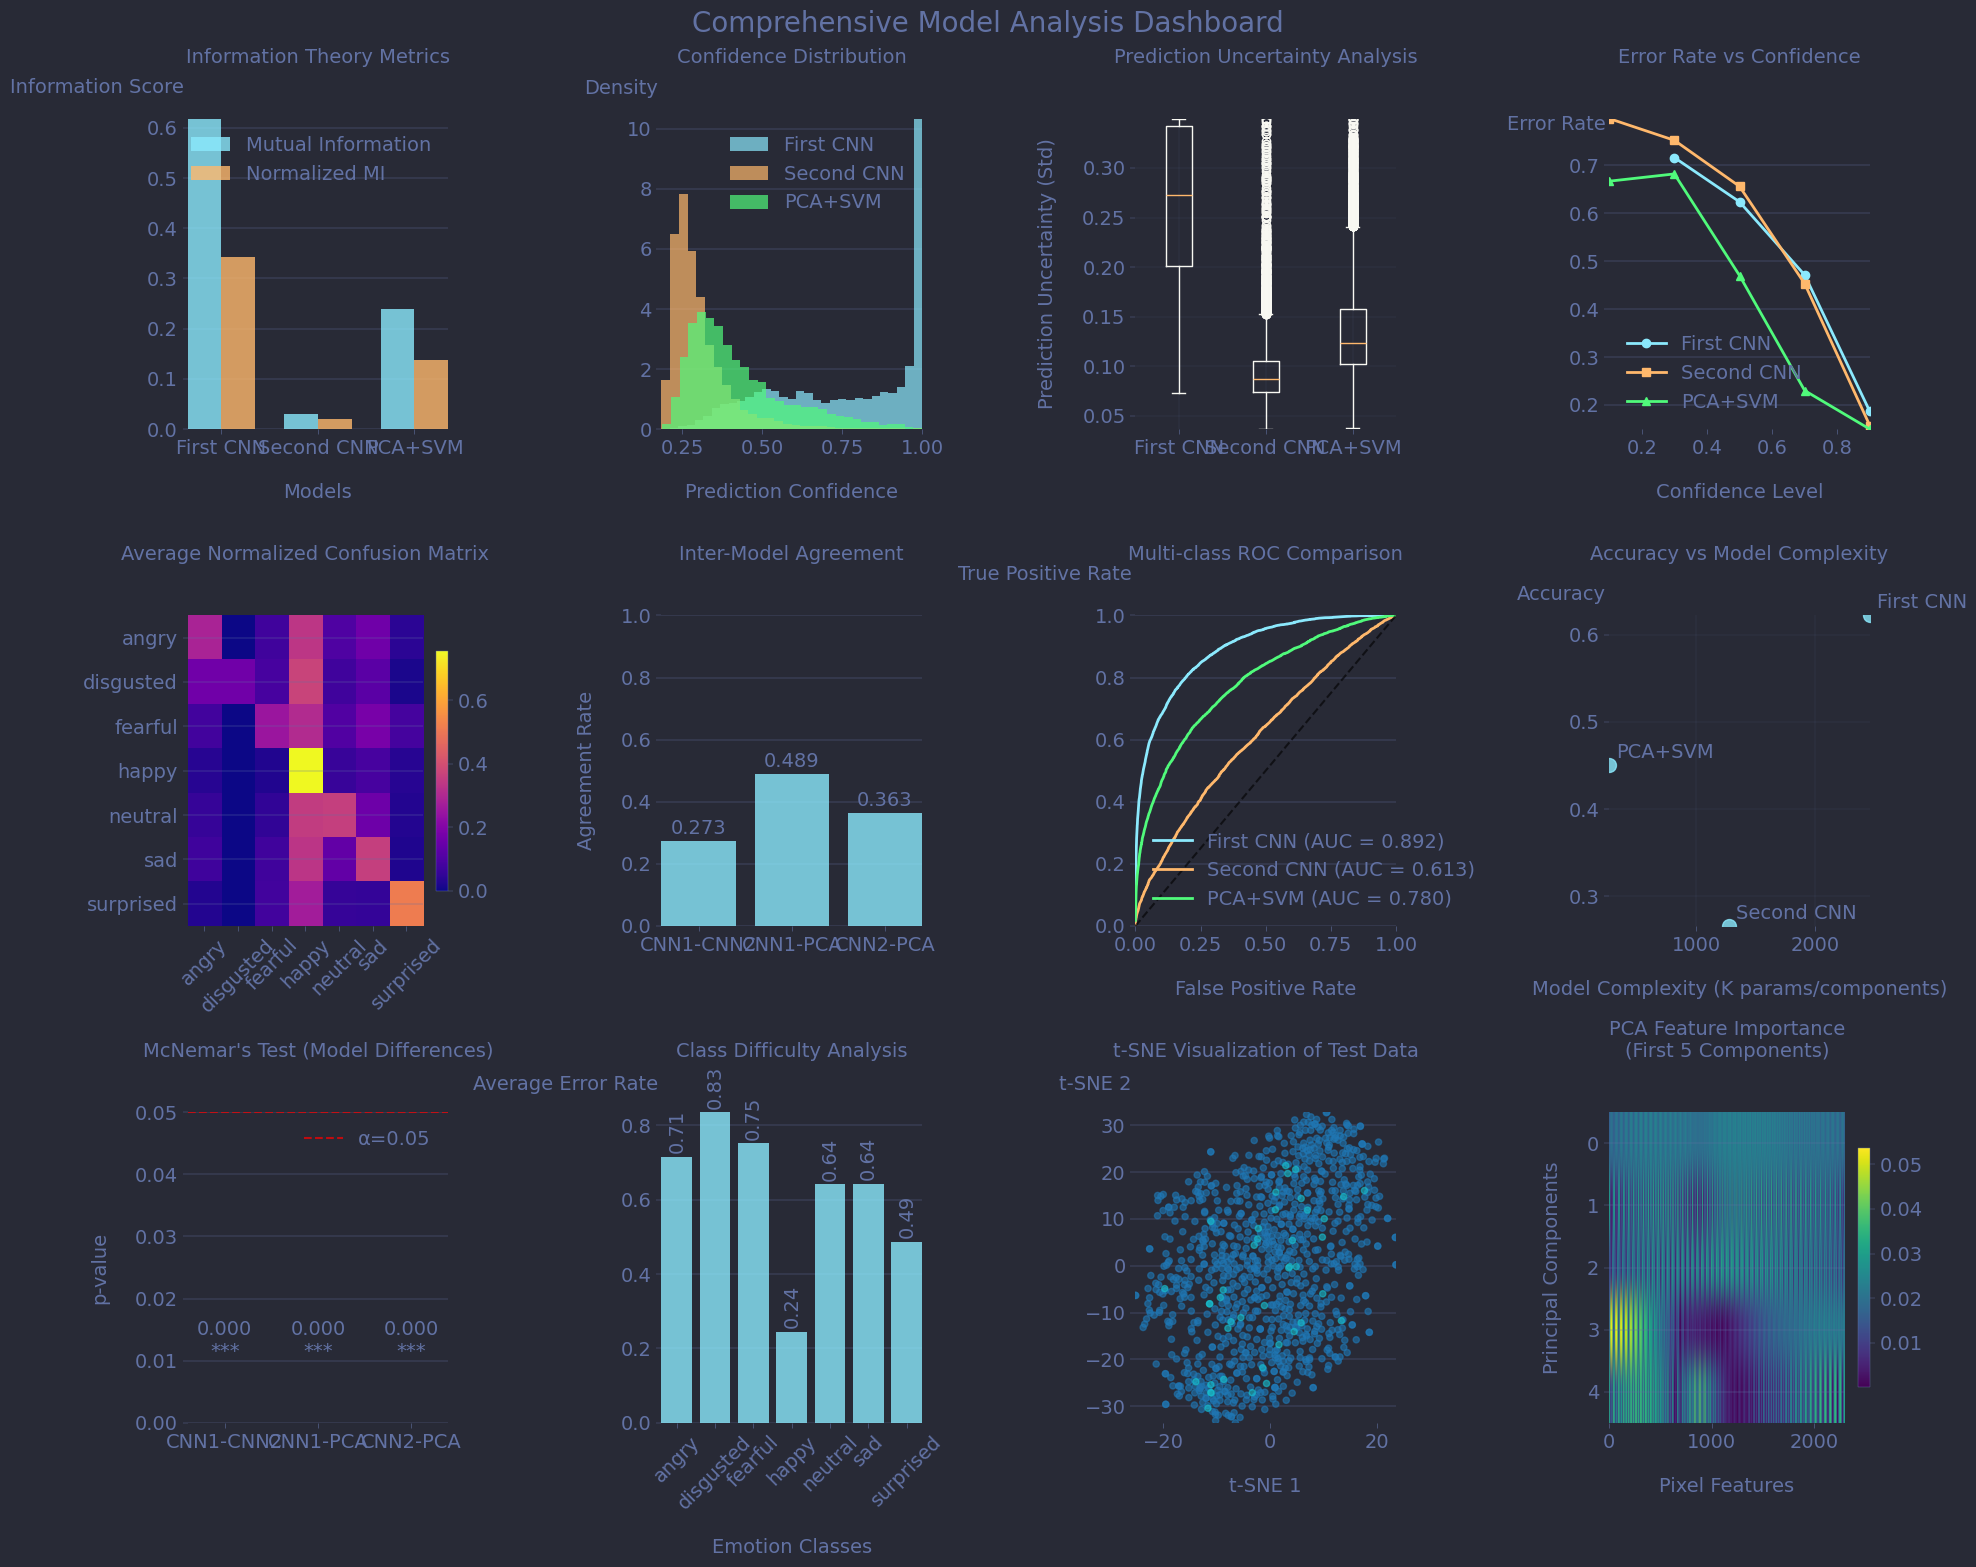


数学分析结果:
Metric                    First CNN    Second CNN   PCA+SVM     
-----------------------------------------------------------------
Mutual Information        0.6185       0.0306       0.2391      
Normalized MI             0.3438       0.0210       0.1384      
Prediction Entropy        1.7857       1.0973       1.6426      
Avg Confidence            0.7563       0.3059       0.4256      
Confidence Std            0.2211       0.1011       0.1555      


In [30]:
# 11. 全局深度数据分析与数学洞察
print("=" * 80)
print("                        全局深度数据分析与数学洞察")
print("=" * 80)


from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
import scipy.cluster.hierarchy as sch
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 第一部分：全局模型性能数学分析
# ============================================================================

def comprehensive_model_analysis():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # First CNN预测
    first_model.eval()
    first_preds, first_probs, first_true = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = first_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            first_probs.extend(probs.cpu().numpy())
            first_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            first_true.extend(labels.numpy())
    
    # Second CNN预测
    second_model.eval()
    second_preds, second_probs = [], []
    with torch.no_grad():
        for inputs, labels in cropped_test_loader:
            inputs = inputs.to(device)
            outputs = second_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            second_probs.extend(probs.cpu().numpy())
            second_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    
    first_probs = np.array(first_probs)
    second_probs = np.array(second_probs)
    first_preds = np.array(first_preds)
    second_preds = np.array(second_preds)
    first_true = np.array(first_true)
    
    min_len = min(len(first_preds), len(second_preds), len(pca_svm_pred_full))
    first_preds = first_preds[:min_len]
    second_preds = second_preds[:min_len]
    first_probs = first_probs[:min_len]
    second_probs = second_probs[:min_len]
    first_true = first_true[:min_len]
    pca_svm_pred_subset = pca_svm_pred_full[:min_len]
    pca_svm_proba_subset = pca_svm_proba_full[:min_len]
    y_test_subset = y_test_full[:min_len]
    
    # 计算信息论指标
    def calculate_information_metrics(y_true, y_pred):
        """计算信息论相关指标"""
        mi = mutual_info_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
        entropy_true = stats.entropy(np.bincount(y_true))
        entropy_pred = stats.entropy(np.bincount(y_pred))
        return mi, nmi, entropy_true, entropy_pred
    
    # 计算各模型的信息论指标
    mi1, nmi1, ent_true1, ent_pred1 = calculate_information_metrics(first_true, first_preds)
    mi2, nmi2, ent_true2, ent_pred2 = calculate_information_metrics(y_test_subset, second_preds)
    mi3, nmi3, ent_true3, ent_pred3 = calculate_information_metrics(y_test_subset, pca_svm_pred_subset)
    
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)):
        fig = plt.figure(figsize=(20, 16))
        
        # 子图1: 信息论指标对比
        ax1 = plt.subplot(3, 4, 1)
        models = ['First CNN', 'Second CNN', 'PCA+SVM']
        mutual_infos = [mi1, mi2, mi3]
        normalized_mis = [nmi1, nmi2, nmi3]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, mutual_infos, width, label='Mutual Information', alpha=0.8)
        bars2 = ax1.bar(x + width/2, normalized_mis, width, label='Normalized MI', alpha=0.8)
        
        ax1.set_xlabel('Models')
        matplotx.ylabel_top('Information Score', ax=ax1)
        ax1.set_title('Information Theory Metrics')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models)
        ax1.legend()
        
        # 子图2: 预测置信度分布
        ax2 = plt.subplot(3, 4, 2)
        first_conf = np.max(first_probs, axis=1)
        second_conf = np.max(second_probs, axis=1)
        pca_conf = np.max(pca_svm_proba_subset, axis=1)
        
        ax2.hist(first_conf, bins=30, alpha=0.7, label='First CNN', density=True)
        ax2.hist(second_conf, bins=30, alpha=0.7, label='Second CNN', density=True)
        ax2.hist(pca_conf, bins=30, alpha=0.7, label='PCA+SVM', density=True)
        ax2.set_xlabel('Prediction Confidence')
        matplotx.ylabel_top('Density', ax=ax2)
        ax2.set_title('Confidence Distribution')
        ax2.legend()
        
        # 子图3: 预测概率的标准差分析
        ax3 = plt.subplot(3, 4, 3)
        first_std = np.std(first_probs, axis=1)
        second_std = np.std(second_probs, axis=1)
        pca_std = np.std(pca_svm_proba_subset, axis=1)
        
        ax3.boxplot([first_std, second_std, pca_std], labels=models)
        ax3.set_ylabel('Prediction Uncertainty (Std)')
        ax3.set_title('Prediction Uncertainty Analysis')
        ax3.grid(True, alpha=0.3)
        
        # 子图4: 错误分析 - 按置信度分层
        ax4 = plt.subplot(3, 4, 4)
        
        def error_by_confidence(y_true, y_pred, confidence, bins=5):
            """按置信度分析错误率"""
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            confidence = np.array(confidence)
            
            conf_bins = np.linspace(0, 1, bins+1)
            error_rates = []
            bin_centers = []
            
            for i in range(bins):
                mask = (confidence >= conf_bins[i]) & (confidence < conf_bins[i+1])
                if np.sum(mask) > 0:
                    # 确保索引正确
                    y_true_masked = y_true[mask]
                    y_pred_masked = y_pred[mask]
                    error_rate = 1 - np.mean(y_true_masked == y_pred_masked)
                    error_rates.append(error_rate)
                    bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)
            
            return bin_centers, error_rates
        
        first_bins, first_errors = error_by_confidence(first_true, first_preds, first_conf)
        second_bins, second_errors = error_by_confidence(y_test_subset, second_preds, second_conf)
        pca_bins, pca_errors = error_by_confidence(y_test_subset, pca_svm_pred_subset, pca_conf)
        
        ax4.plot(first_bins, first_errors, 'o-', label='First CNN', linewidth=2)
        ax4.plot(second_bins, second_errors, 's-', label='Second CNN', linewidth=2)
        ax4.plot(pca_bins, pca_errors, '^-', label='PCA+SVM', linewidth=2)
        ax4.set_xlabel('Confidence Level')
        matplotx.ylabel_top('Error Rate', ax=ax4)
        ax4.set_title('Error Rate vs Confidence')
        ax4.legend()
        
        # 子图5: 类别间混淆热力图
        ax5 = plt.subplot(3, 4, 5)
        
        # 计算平均混淆矩阵
        cm1 = confusion_matrix(first_true, first_preds, normalize='true')
        cm2 = confusion_matrix(y_test_subset, second_preds, normalize='true')
        cm3 = confusion_matrix(y_test_subset, pca_svm_pred_subset, normalize='true')
        
        avg_cm = (cm1 + cm2 + cm3) / 3
        
        im = ax5.imshow(avg_cm, cmap='plasma', aspect='auto')
        ax5.set_xticks(range(len(test_dataset.classes)))
        ax5.set_yticks(range(len(test_dataset.classes)))
        ax5.set_xticklabels(test_dataset.classes, rotation=45)
        ax5.set_yticklabels(test_dataset.classes)
        ax5.set_title('Average Normalized Confusion Matrix')
        plt.colorbar(im, ax=ax5, fraction=0.046)
        
        # 子图6: 预测一致性分析
        ax6 = plt.subplot(3, 4, 6)
        
        # 计算模型间的预测一致性
        agreement_12 = np.mean(first_preds == second_preds)
        agreement_13 = np.mean(first_preds == pca_svm_pred_subset)
        agreement_23 = np.mean(second_preds == pca_svm_pred_subset)
        
        agreements = [agreement_12, agreement_13, agreement_23]
        pair_labels = ['CNN1-CNN2', 'CNN1-PCA', 'CNN2-PCA']
        
        bars = ax6.bar(pair_labels, agreements, alpha=0.8)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        ax6.set_ylabel('Agreement Rate')
        ax6.set_title('Inter-Model Agreement')
        ax6.set_ylim(0, 1)
        
        # 子图7: ROC曲线比较 (多类别平均)
        ax7 = plt.subplot(3, 4, 7)
        
        def plot_multiclass_roc(y_true, y_score, ax, label):
            n_classes = len(np.unique(y_true))
            y_true_bin = np.eye(n_classes)[y_true]
            
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                if i < y_score.shape[1]:  # 确保类别索引存在
                    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
            
            # 计算平均ROC
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(fpr))]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(len(fpr)):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= len(fpr)
            
            mean_auc = auc(all_fpr, mean_tpr)
            ax.plot(all_fpr, mean_tpr, linewidth=2, 
                   label=f'{label} (AUC = {mean_auc:.3f})')
            
            return mean_auc
        
        auc1 = plot_multiclass_roc(first_true, first_probs, ax7, 'First CNN')
        auc2 = plot_multiclass_roc(y_test_subset, second_probs, ax7, 'Second CNN')
        auc3 = plot_multiclass_roc(y_test_subset, pca_svm_proba_subset, ax7, 'PCA+SVM')
        
        ax7.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        ax7.set_xlabel('False Positive Rate')
        matplotx.ylabel_top('True Positive Rate', ax=ax7)
        ax7.set_title('Multi-class ROC Comparison')
        ax7.legend()
        
        # 子图8: 学习曲线分析（基于复杂度）
        ax8 = plt.subplot(3, 4, 8)
        
        first_params = sum(p.numel() for p in first_model.parameters())
        second_params = sum(p.numel() for p in second_model.parameters())
        pca_components = pca_svm_model_full.named_steps['pca'].n_components_
        
        complexities = [first_params/1000, second_params/1000, pca_components]
        accuracies = [first_model_accuracy, second_model_accuracy, pca_svm_accuracy_full]
        
        ax8.scatter(complexities, accuracies, s=100, alpha=0.8)
        for i, model in enumerate(models):
            ax8.annotate(model, (complexities[i], accuracies[i]), 
                        xytext=(5, 5), textcoords='offset points')
        
        ax8.set_xlabel('Model Complexity (K params/components)')
        matplotx.ylabel_top('Accuracy', ax=ax8)
        ax8.set_title('Accuracy vs Model Complexity')
        ax8.grid(True, alpha=0.3)
        
        # 子图9: 统计显著性测试
        ax9 = plt.subplot(3, 4, 9)
        
        # McNemar's test for paired comparisons
        try:
            from statsmodels.stats.contingency_tables import mcnemar
            
            def mcnemar_test(y_true, y_pred1, y_pred2):
                """执行McNemar测试"""
                correct1 = (y_true == y_pred1)
                correct2 = (y_true == y_pred2)
                
                a = np.sum(correct1 & correct2)  # 都对
                b = np.sum(correct1 & ~correct2)  # 1对2错
                c = np.sum(~correct1 & correct2)  # 1错2对
                d = np.sum(~correct1 & ~correct2)  # 都错
                
                table = np.array([[a, b], [c, d]])
                if b + c > 0:
                    result = mcnemar(table, exact=False)
                    return result.pvalue
                return 1.0
            
            p_12 = mcnemar_test(y_test_subset, first_preds, second_preds)
            p_13 = mcnemar_test(y_test_subset, first_preds, pca_svm_pred_subset)
            p_23 = mcnemar_test(y_test_subset, second_preds, pca_svm_pred_subset)
            
            p_values = [p_12, p_13, p_23]
            
            bars = ax9.bar(pair_labels, p_values, alpha=0.8)
            ax9.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
            
            for i, bar in enumerate(bars):
                height = bar.get_height()
                significance = '***' if height < 0.001 else '**' if height < 0.01 else '*' if height < 0.05 else 'ns'
                ax9.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}\n{significance}', ha='center', va='bottom')
            
            ax9.set_ylabel('p-value')
            ax9.set_title("McNemar's Test (Model Differences)")
            ax9.legend()
            
        except ImportError:
            ax9.text(0.5, 0.5, 'statsmodels not available\nfor McNemar test', 
                    ha='center', va='center', transform=ax9.transAxes)
            ax9.set_title("McNemar's Test (Not Available)")
            p_values = [0.5, 0.5, 0.5]  # Default values
        
        # 子图10: 类别难度分析
        ax10 = plt.subplot(3, 4, 10)
        
        class_difficulties = []
        for class_idx in range(len(test_dataset.classes)):
            mask = (y_test_subset == class_idx)
            if np.sum(mask) > 0:
                error1 = 1 - np.mean(first_preds[mask] == class_idx)
                error2 = 1 - np.mean(second_preds[mask] == class_idx)
                error3 = 1 - np.mean(pca_svm_pred_subset[mask] == class_idx)
                avg_error = (error1 + error2 + error3) / 3
                class_difficulties.append(avg_error)
            else:
                class_difficulties.append(0)
        
        bars = ax10.bar(test_dataset.classes, class_difficulties, alpha=0.8)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax10.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.2f}', ha='center', va='bottom', rotation=90)
        
        ax10.set_xlabel('Emotion Classes')
        matplotx.ylabel_top('Average Error Rate', ax=ax10)
        ax10.set_title('Class Difficulty Analysis')
        ax10.set_xticklabels(test_dataset.classes, rotation=45)
        
        # 子图11: 决策边界分析（使用t-SNE）
        ax11 = plt.subplot(3, 4, 11)
        

        X_sample = X_test_full[:1000] 
        y_sample = y_test_full[:1000]
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(X_sample)
        
        scatter = ax11.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, 
                              cmap='tab10', alpha=0.6, s=20)
        ax11.set_title('t-SNE Visualization of Test Data')
        ax11.set_xlabel('t-SNE 1')
        matplotx.ylabel_top('t-SNE 2', ax=ax11)
        
        # 子图12: 特征重要性热力图
        ax12 = plt.subplot(3, 4, 12)
        

        pca_component = pca_svm_model_full.named_steps['pca']
        feature_importance = np.abs(pca_component.components_[:5])  
        
        im = ax12.imshow(feature_importance, cmap='viridis', aspect='auto')
        ax12.set_title('PCA Feature Importance\n(First 5 Components)')
        ax12.set_xlabel('Pixel Features')
        ax12.set_ylabel('Principal Components')
        plt.colorbar(im, ax=ax12, fraction=0.046)
        
        plt.suptitle('Comprehensive Model Analysis Dashboard', fontsize=20, y=0.98)
        plt.tight_layout()
        plt.show()
    
    print(f"\n数学分析结果:")
    print(f"{'Metric':<25} {'First CNN':<12} {'Second CNN':<12} {'PCA+SVM':<12}")
    print("-" * 65)
    print(f"{'Mutual Information':<25} {mi1:<12.4f} {mi2:<12.4f} {mi3:<12.4f}")
    print(f"{'Normalized MI':<25} {nmi1:<12.4f} {nmi2:<12.4f} {nmi3:<12.4f}")
    print(f"{'Prediction Entropy':<25} {ent_pred1:<12.4f} {ent_pred2:<12.4f} {ent_pred3:<12.4f}")
    print(f"{'Avg Confidence':<25} {np.mean(first_conf):<12.4f} {np.mean(second_conf):<12.4f} {np.mean(pca_conf):<12.4f}")
    print(f"{'Confidence Std':<25} {np.std(first_conf):<12.4f} {np.std(second_conf):<12.4f} {np.std(pca_conf):<12.4f}")
    
    return {
        'mutual_info': [mi1, mi2, mi3],
        'normalized_mi': [nmi1, nmi2, nmi3],
        'confidences': [first_conf, second_conf, pca_conf],
        'agreements': [agreement_12, agreement_13, agreement_23],
        'p_values': p_values if 'p_values' in locals() else [0.5, 0.5, 0.5],
        'class_difficulties': class_difficulties
    }

global_analysis = comprehensive_model_analysis()


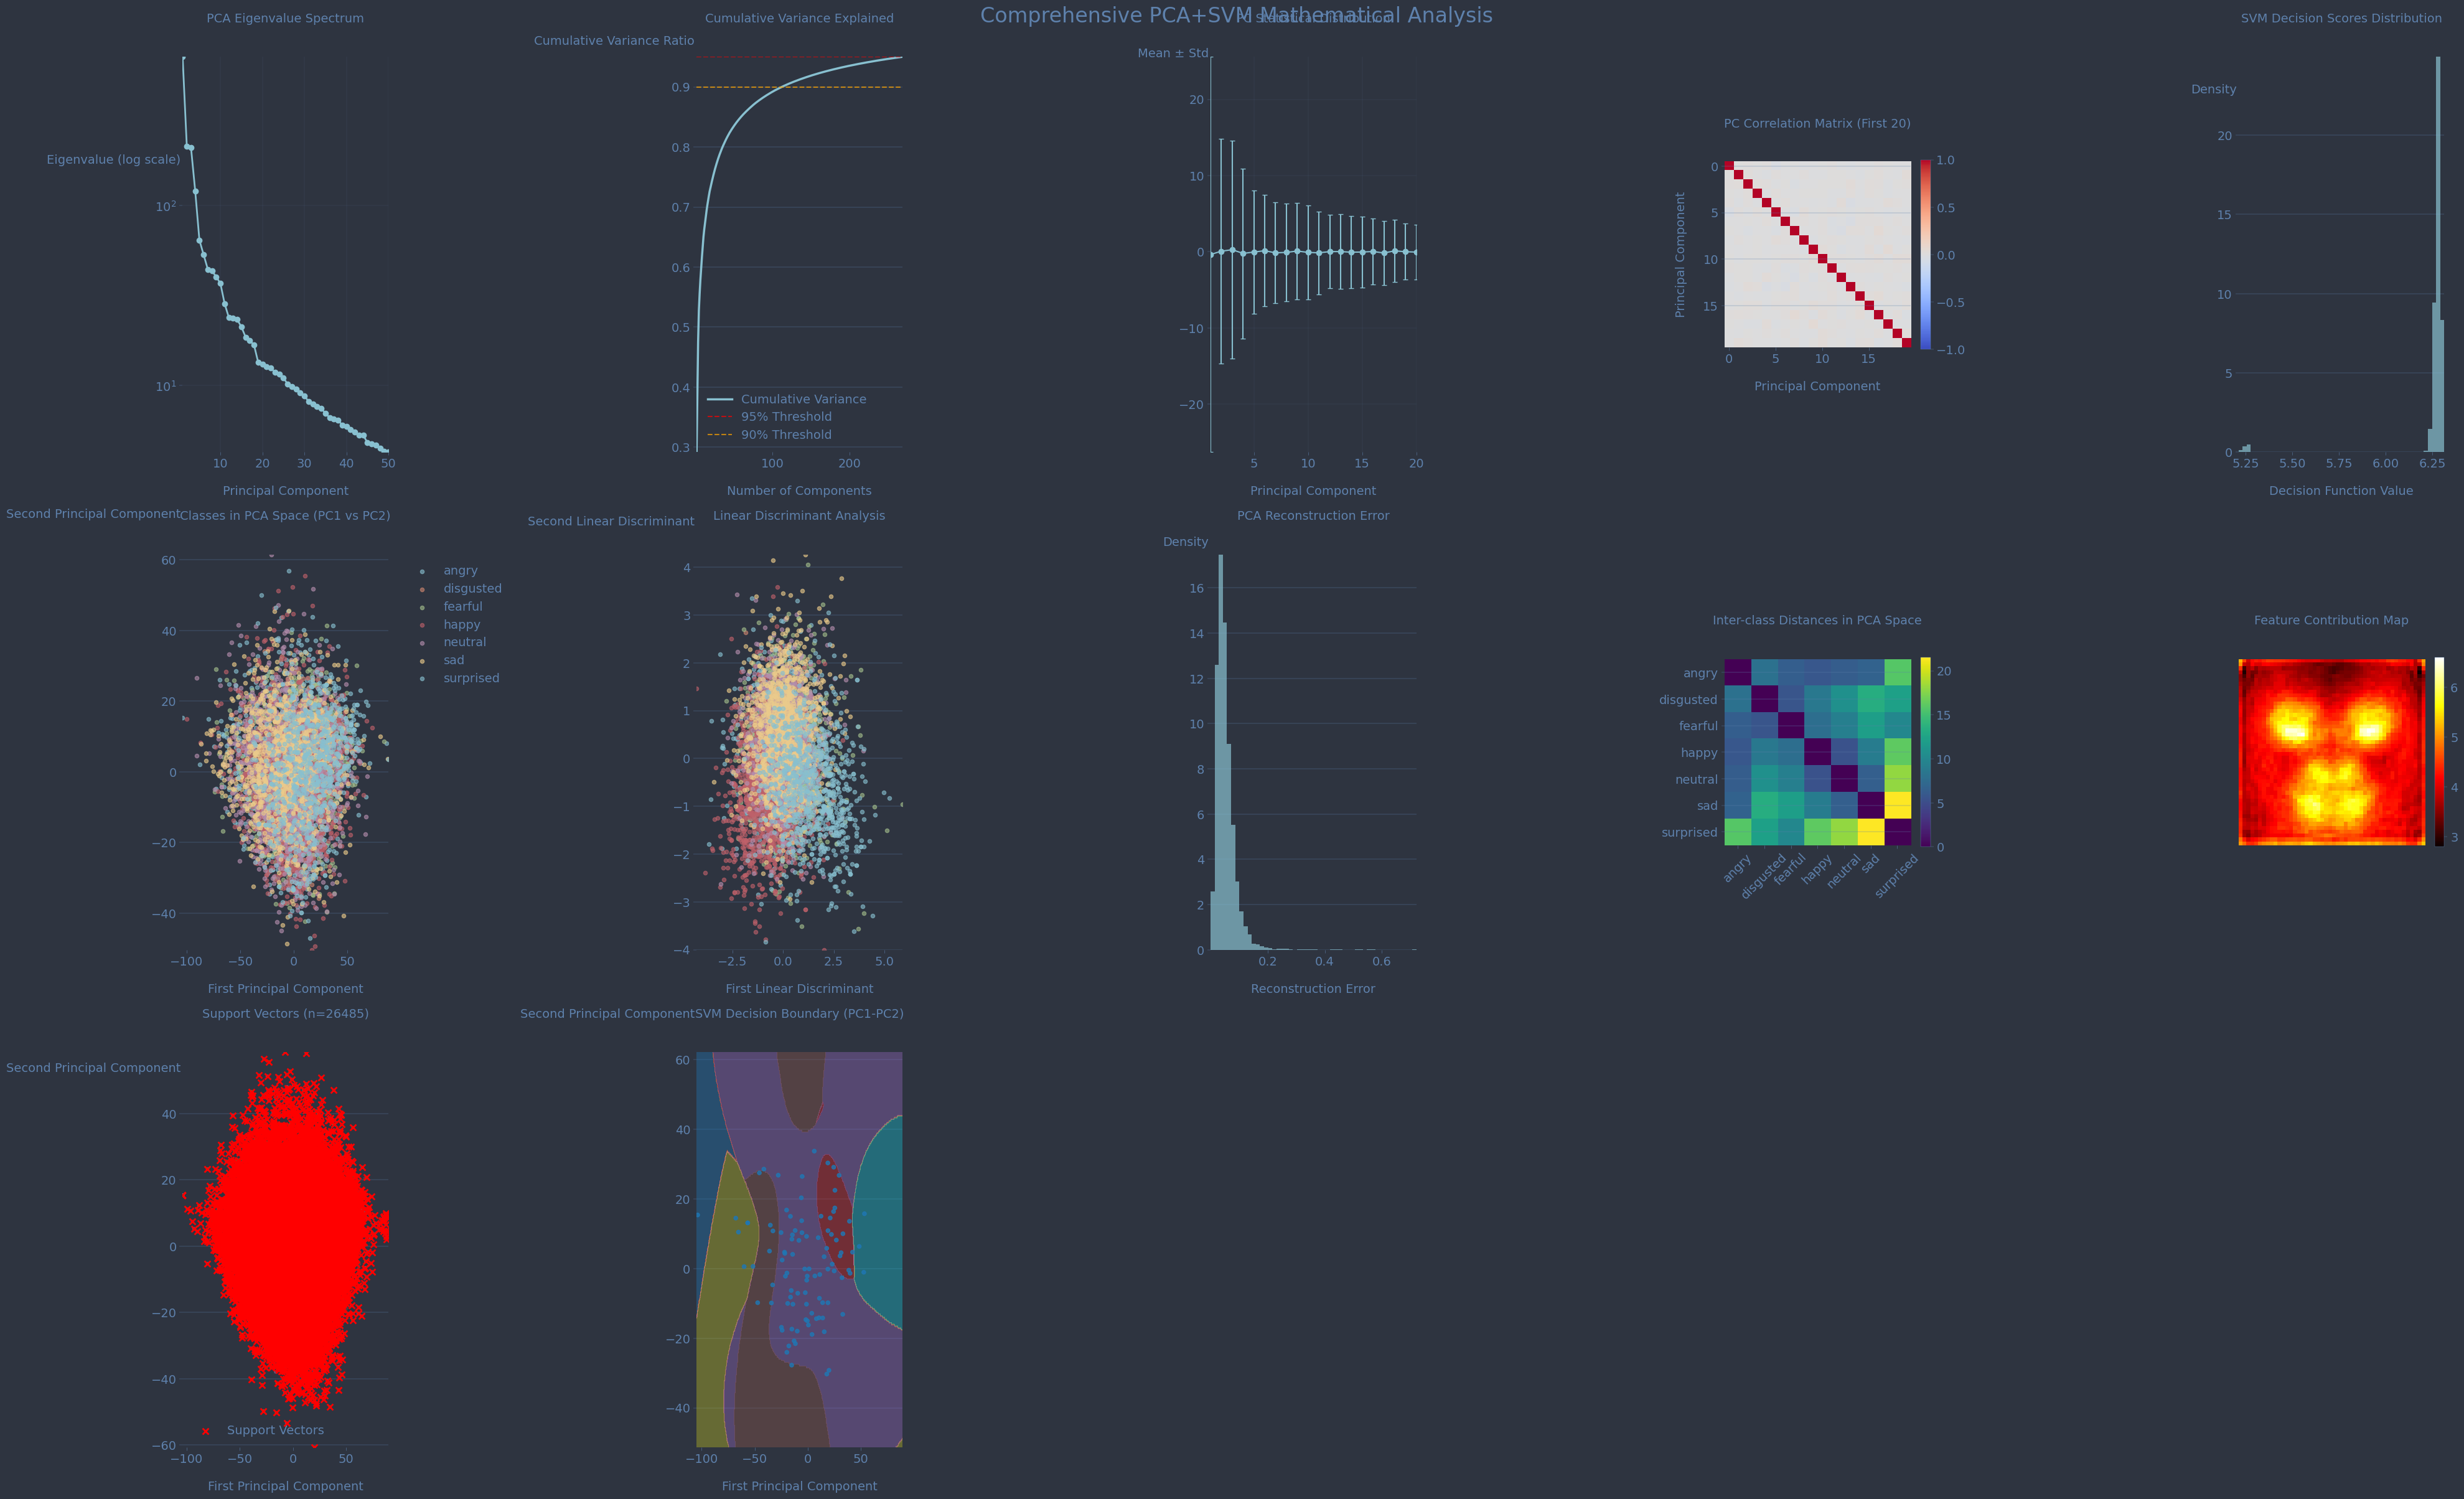


PCA 分析:
  总特征数量: 2304
  保留的主成分: 269
  维度减少比例: 88.3%
  解释的总方差: 0.9501
  第一主成分贡献: 0.2916
  特征值条件数: 1.67e+03

SVM 分析:
  支持向量数量: 26485
  支持向量比例: 368.97%
  核函数类型: rbf
  正则化参数 C: 1.0
  RBF gamma 参数: scale

几何分析:
  平均类间距离: 10.2848
  最大类间距离: 21.5192
  最小类间距离: 5.4002

重构分析:
  平均重构误差: 0.052321
  重构误差标准差: 0.036480
  重构质量指标: 0.9477

预测分析:
  平均预测熵: 1.4925
  预测不确定性: 0.2695
  高置信度预测比例: 3.3%


In [32]:


# ============================================================================
# 第二部分：PCA+SVM 深度数学分析
# ============================================================================

def detailed_pca_svm_analysis():
    

    scaler = pca_svm_model_full.named_steps['scaler']
    pca = pca_svm_model_full.named_steps['pca']
    svm = pca_svm_model_full.named_steps['svm']
    X_scaled = scaler.transform(X_test_full)
    X_pca = pca.transform(X_scaled)
    X_train_scaled = scaler.transform(X_train_full)
    X_train_pca = pca.transform(X_train_scaled)
    
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.nord)):
        fig = plt.figure(figsize=(40, 32))
        plt.suptitle('Comprehensive PCA+SVM Mathematical Analysis', fontsize=30, y=0.98)

        plt.subplots_adjust(
            left=0.04,
            right=0.97,
            top=0.94,
            bottom=0.05,
            wspace=0.5,
            hspace=0.8
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])  
        # 子图1: 特征值分析
        ax1 = plt.subplot(4, 5, 1)
        eigenvalues = pca.explained_variance_
        ax1.semilogy(range(1, min(51, len(eigenvalues)+1)), eigenvalues[:50], 'o-', linewidth=2)
        ax1.set_xlabel('Principal Component')
        matplotx.ylabel_top('Eigenvalue (log scale)', ax=ax1)
        ax1.set_title('PCA Eigenvalue Spectrum')
        ax1.grid(True, alpha=0.3)
        
        # 子图2: 累积方差比解释
        ax2 = plt.subplot(4, 5, 2)
        cumvar = np.array(np.cumsum(pca.explained_variance_ratio_))
        ax2.plot(range(1, len(cumvar)+1), cumvar, linewidth=2.5, label='Cumulative Variance')
        ax2.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Threshold')
        ax2.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% Threshold')
        ax2.set_xlabel('Number of Components')
        matplotx.ylabel_top('Cumulative Variance Ratio', ax=ax2)
        ax2.set_title('Cumulative Variance Explained')
        ax2.legend()
        
        # 子图3: 主成分的统计分布
        ax3 = plt.subplot(4, 5, 3)
        pc_means = np.mean(X_pca, axis=0)
        pc_stds = np.std(X_pca, axis=0)
        
        x_pc = range(1, min(21, len(pc_means)+1))
        ax3.errorbar(x_pc, pc_means[:20], yerr=pc_stds[:20], fmt='o-', capsize=3)
        ax3.set_xlabel('Principal Component')
        matplotx.ylabel_top('Mean ± Std', ax=ax3)
        ax3.set_title('PC Statistical Distribution')
        ax3.grid(True, alpha=0.3)
        
        # 子图4: 主成分相关性热力图
        ax4 = plt.subplot(4, 5, 4)
        pc_corr = np.corrcoef(X_pca[:, :20].T)
        im = ax4.imshow(pc_corr, cmap='coolwarm', vmin=-1, vmax=1)
        ax4.set_title('PC Correlation Matrix (First 20)')
        ax4.set_xlabel('Principal Component')
        ax4.set_ylabel('Principal Component')
        plt.colorbar(im, ax=ax4, fraction=0.046)
        
        # 子图5: 支持向量分析
        ax5 = plt.subplot(4, 5, 5)
        
        # 计算决策函数值
        decision_scores = svm.decision_function(X_pca)
        if decision_scores.ndim > 1:
            decision_scores = np.max(np.abs(decision_scores), axis=1)
        
        ax5.hist(decision_scores, bins=50, alpha=0.7, density=True)
        ax5.set_xlabel('Decision Function Value')
        matplotx.ylabel_top('Density', ax=ax5)
        ax5.set_title('SVM Decision Scores Distribution')
        
        # 子图6: 类别在PCA空间的分布
        ax6 = plt.subplot(4, 5, 6)
        
        # 选择前两个主成分进行可视化
        for class_idx in range(len(test_dataset.classes)):
            mask = (y_test_full == class_idx)
            if np.sum(mask) > 0:
                ax6.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                           label=test_dataset.classes[class_idx], alpha=0.6, s=20)
        
        ax6.set_xlabel('First Principal Component')
        matplotx.ylabel_top('Second Principal Component', ax=ax6)
        ax6.set_title('Classes in PCA Space (PC1 vs PC2)')
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 子图7: 判别分析
        ax7 = plt.subplot(4, 5, 7)
        
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_lda = lda.fit_transform(X_pca, y_test_full)
        
        for class_idx in range(len(test_dataset.classes)):
            mask = (y_test_full == class_idx)
            if np.sum(mask) > 0:
                ax7.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                           label=test_dataset.classes[class_idx], alpha=0.6, s=20)
        
        ax7.set_xlabel('First Linear Discriminant')
        matplotx.ylabel_top('Second Linear Discriminant', ax=ax7)
        ax7.set_title('Linear Discriminant Analysis')
        
        # 子图8: 重构误差分析
        ax8 = plt.subplot(4, 5, 8)
        
        X_reconstructed = pca.inverse_transform(X_pca)
        reconstruction_errors = np.mean((X_scaled - X_reconstructed)**2, axis=1)
        
        ax8.hist(reconstruction_errors, bins=50, alpha=0.7, density=True)
        ax8.set_xlabel('Reconstruction Error')
        matplotx.ylabel_top('Density', ax=ax8)
        ax8.set_title('PCA Reconstruction Error')
        
        # 子图9: 类别分离度分析
        ax9 = plt.subplot(4, 5, 9)

        class_centers = []
        for class_idx in range(len(test_dataset.classes)):
            mask = (y_test_full == class_idx)
            if np.sum(mask) > 0:
                center = np.mean(X_pca[mask], axis=0)
                class_centers.append(center)
        
        class_centers = np.array(class_centers)
        distances = pdist(class_centers)
        distance_matrix = squareform(distances)
        
        im = ax9.imshow(distance_matrix, cmap='viridis')
        ax9.set_xticks(range(len(test_dataset.classes)))
        ax9.set_yticks(range(len(test_dataset.classes)))
        ax9.set_xticklabels(test_dataset.classes, rotation=45)
        ax9.set_yticklabels(test_dataset.classes)
        ax9.set_title('Inter-class Distances in PCA Space')
        plt.colorbar(im, ax=ax9, fraction=0.046)
        
        # 子图10: 维度贡献分析
        ax10 = plt.subplot(4, 5, 10)

        feature_contributions = np.sum(np.abs(pca.components_), axis=0)

        contribution_map = feature_contributions.reshape(48, 48)
        im = ax10.imshow(contribution_map, cmap='hot')
        ax10.set_title('Feature Contribution Map')
        ax10.axis('off')
        plt.colorbar(im, ax=ax10, fraction=0.046)
        
        # 子图12: 支持向量可视化
        ax12 = plt.subplot(4, 5, 11)
        
        # 找到支持向量
        support_vectors = svm.support_
        
        # 在PCA空间中可视化支持向量
        ax12.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_full, alpha=0.3, s=10, cmap='tab10')
        ax12.scatter(X_train_pca[support_vectors, 0], X_train_pca[support_vectors, 1], 
             c='red', s=50, marker='x', linewidths=2, label='Support Vectors')  
        ax12.set_xlabel('First Principal Component')
        matplotx.ylabel_top('Second Principal Component', ax=ax12)
        ax12.set_title(f'Support Vectors (n={len(support_vectors)})')
        ax12.legend()
        
        # 子图13: 决策边界复杂度
        ax13 = plt.subplot(4, 5, 12)
        h = 0.5
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_extended = np.zeros((grid_points.shape[0], X_pca.shape[1]))
        grid_extended[:, :2] = grid_points
        
        Z = svm.predict(grid_extended)
        Z = Z.reshape(xx.shape)
        
        ax13.contourf(xx, yy, Z, alpha=0.4, cmap='tab10')
        ax13.scatter(X_pca[:100, 0], X_pca[:100, 1], c=y_test_full[:100], 
                    cmap='tab10', s=20, alpha=0.8)
        ax13.set_title('SVM Decision Boundary (PC1-PC2)')
        ax13.set_xlabel('First Principal Component')
        matplotx.ylabel_top('Second Principal Component', ax=ax13)
        
        
        plt.suptitle('Comprehensive PCA+SVM Mathematical Analysis', fontsize=24, y=0.98)
        plt.tight_layout()
        plt.show()
    print(f"\nPCA 分析:")
    print(f"  总特征数量: {X_scaled.shape[1]}")
    print(f"  保留的主成分: {pca.n_components_}")
    print(f"  维度减少比例: {(1 - pca.n_components_/X_scaled.shape[1])*100:.1f}%")
    print(f"  解释的总方差: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"  第一主成分贡献: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"  特征值条件数: {eigenvalues[0]/eigenvalues[-1]:.2e}")
    
    print(f"\nSVM 分析:")
    print(f"  支持向量数量: {len(svm.support_)}")
    print(f"  支持向量比例: {len(svm.support_)/len(X_pca)*100:.2f}%")
    print(f"  核函数类型: {svm.kernel}")
    print(f"  正则化参数 C: {svm.C}")
    if hasattr(svm, 'gamma'):
        print(f"  RBF gamma 参数: {svm.gamma}")
    
    class_centers = []
    for class_idx in range(len(test_dataset.classes)):
        mask = (y_test_full == class_idx)
        if np.sum(mask) > 0:
            center = np.mean(X_pca[mask], axis=0)
            class_centers.append(center)
    
    class_centers = np.array(class_centers)
    distances = pdist(class_centers)
    
    print(f"\n几何分析:")
    avg_class_separation = np.mean(distances)
    print(f"  平均类间距离: {avg_class_separation:.4f}")
    print(f"  最大类间距离: {np.max(distances):.4f}")
    print(f"  最小类间距离: {np.min(distances[distances > 0]):.4f}")
    

    X_reconstructed = pca.inverse_transform(X_pca)
    reconstruction_errors = np.mean((X_scaled - X_reconstructed)**2, axis=1)
    
    print(f"\n重构分析:")
    print(f"  平均重构误差: {np.mean(reconstruction_errors):.6f}")
    print(f"  重构误差标准差: {np.std(reconstruction_errors):.6f}")
    print(f"  重构质量指标: {1 - np.mean(reconstruction_errors):.4f}")
    
    print(f"\n预测分析:")
    entropy_probs = -np.sum(pca_svm_proba_full * np.log(pca_svm_proba_full + 1e-15), axis=1)
    print(f"  平均预测熵: {np.mean(entropy_probs):.4f}")
    print(f"  预测不确定性: {np.std(entropy_probs):.4f}")
    print(f"  高置信度预测比例: {np.mean(np.max(pca_svm_proba_full, axis=1) > 0.8)*100:.1f}%")
    
    return {
        'pca_components': pca.n_components_,
        'explained_variance': np.sum(pca.explained_variance_ratio_),
        'support_vectors_ratio': len(svm.support_)/len(X_pca),
        'reconstruction_error': np.mean(reconstruction_errors),
        'class_separation': avg_class_separation,
        'prediction_entropy': np.mean(entropy_probs)
    }

pca_analysis = detailed_pca_svm_analysis()


